In [35]:
import torch
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

import utils
from importlib import reload
reload(utils)

<module 'utils' from '/datadrive1/ken/projects/rft-experiments/utils.py'>

In [2]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

ds = datasets.load_dataset("openai/gsm8k", "main")

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


### Getting basic sense of the data
* Number of steps to solve the problem

Text(0, 0.5, 'Count')

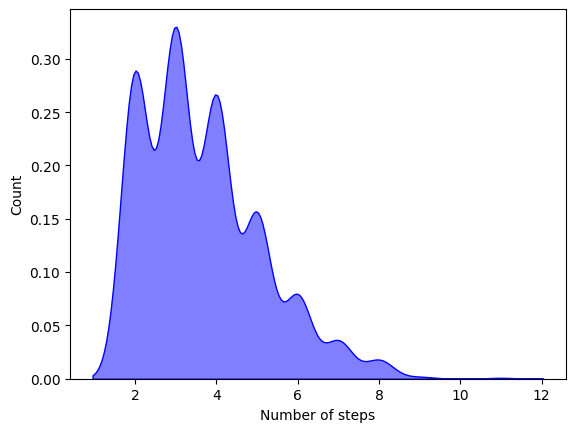

In [63]:
# Count for each answer how many lines it has
# (except the last line, which is the answer)
num_steps = []
for answer in ds["test"]["answer"]:
    lines = answer.split("\n")
    num_steps.append(len(lines) - 1)

fig, ax = plt.subplots()
sns.kdeplot(num_steps, ax=ax, fill=True, color="blue", alpha=0.5)
ax.set_xlabel("Number of steps")
ax.set_ylabel("Count")

### Getting a sense of the baseline, not a perfect replication but good to know where we are at.

In [10]:
prompt_template = """You are given a math question. You must provide a concise step-by-step reasoning
    and a final answer. Your response should follow strictly the format of the provided examples where each new line is a reasoning step
    written in a very concise style, and the final answer is on the last line. There should be roughly 2-4 steps, but it is okay
    to have more or less steps if needed.
    
    {n_shot_examples}

    # Question:
    {question}
"""

In [ ]:
def evaluate_model(
        model: AutoModelForCausalLM,
        eval_dataset: datasets.Dataset,
        tokenizer: AutoTokenizer,
        prompt_template: str,
        max_new_tokens: int = 256,
        temperature: float = 0.7,
        batch_size: int = 8,
        num_examples: int = 8,
    ) -> float:
    questions = eval_dataset['question']
    answers = eval_dataset['answer']
    all_scores = []

    # Generate n-shot examples from the dataset
    questions, answers, n_shot_examples = utils.generate_n_shot_examples(
        questions, answers, num_examples
    )
    
    # Process data in batches
    for batch_start in tqdm.tqdm(range(0, len(questions), batch_size), desc="Evaluating model"):
        batch_end = min(batch_start + batch_size, len(questions))
        batch_questions = questions[batch_start:batch_end]
        batch_answers = answers[batch_start:batch_end]
        
        # Prepare batch of formatted chats
        batch_chats = []
        for question in batch_questions:
            chat = [
                {
                    "role": "user",
                    "content": prompt_template.format(question=question, n_shot_examples=n_shot_examples)
                }
            ]
            formatted_chat = tokenizer.apply_chat_template(
                chat, tokenize=False, add_generation_prompt=True
            )
            batch_chats.append(formatted_chat)
        
        # Tokenize batch with padding
        batch_inputs = tokenizer(
            batch_chats,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        input_ids = batch_inputs.input_ids.to("cuda")
        attention_mask = batch_inputs.attention_mask.to("cuda")
        
        # Generate responses for the batch
        with torch.no_grad():
            output_ids = model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                num_return_sequences=1,
                pad_token_id=tokenizer.pad_token_id,
            )
        
        # Decode batch outputs
        batch_predictions = []
        for i in range(len(batch_questions)):
            # Extract only the generated portion (skip input tokens)
            generated_tokens = output_ids[i][len(input_ids[i]):]
            ans_pred = tokenizer.decode(
                generated_tokens,
                skip_special_tokens=True,
            )
            print(f"\n{i}: Decoded answer:\n{ans_pred}")
            batch_predictions.append(ans_pred)
        
        # Evaluate correctness for each item in the batch
        batch_scores = []
        for pred, answer in zip(batch_predictions, batch_answers):
            if utils.is_correct_solution(pred, answer):
                batch_scores.append(1.0)
            else:
                batch_scores.append(0.0)
        
        # Add batch scores to global scores
        all_scores.extend(batch_scores)
    
    # Calculate final accuracy
    return sum(all_scores) / len(all_scores)

In [47]:
# Evaluate the baseline model
print(
    evaluate_model(
        model=model,
        eval_dataset=ds["test"],
        tokenizer=tokenizer,
        prompt_template=prompt_template,
        max_new_tokens=256,
        temperature=0.7,
        batch_size=16,
        num_examples=2,
    )
)

Evaluating model:   0%|          | 0/83 [00:00<?, ?it/s]

Evaluating model:   1%|          | 1/83 [00:11<16:06, 11.79s/it]


0: Decoded answer:
Janet eats 3 eggs for breakfast and uses 4 for baking, which totals 3 + 4 = <<3+4=7>>7 eggs.
She has 16 eggs in total, so she sells 16 - 7 = <<16-7=9>>9 eggs at the farmers' market.
Since she sells each egg for $2, she makes 9 * $2 = $<<9*2=18>>18 every day at the farmers' market.
#### 18

1: Decoded answer:
The robe takes 2 bolts of blue fiber.
It takes half of that amount for white fiber, which is 2/2 = <<2/2=1>>1 bolt.
In total, it takes 2 bolts of blue fiber + 1 bolt of white fiber = <<2+1=3>>3 bolts.
#### 3

2: Decoded answer:
Josh's repairs increased the value of the house by 150%, which means the house's value increased by 150/100 * $80,000 = $120,000.
The total value of the house after repairs is $80,000 + $120,000 = $200,000.
Josh invested $50,000 in repairs, so his total investment is $80,000 + $50,000 = $130,000.
The profit Josh made is $200,000 - $130,000 = $70,000.
#### 70000

3: Decoded answer:
He runs 3 sprints per session, so in one session, he runs 

Evaluating model:   2%|▏         | 2/83 [00:21<14:00, 10.38s/it]


0: Decoded answer:
Train 1 distance: 80 miles westward + 150 miles northward = <<80+150=230>>230 miles
Train 2 distance: 80 miles westward + 150 miles northward = <<80+150=230>>230 miles

#### 230 miles



1: Decoded answer:
Jill earns $20/hour x 35 hours/week = <<20*35=700>>700 per week as a teacher.
She earns $30/hour x 15 hours/week = <<30*15=450>>450 per week as a coach.
Total weekly earnings: $700 + $450 = <<700+450=1150>>1150
Annual earnings: $1150/week x 50 weeks/year = <<1150*50=57500>>57,500
#### 57500

2: Decoded answer:
Claire eats 3 eggs per day.
There are 7 days in a week, so she eats 3 x 7 = <<3*7=21>>21 eggs per week.
In 4 weeks, she will eat 21 x 4 = <<21*4=84>>84 eggs.
Since 1 dozen equals 12 eggs, she will eat 84 / 12 = <<84/12=7>>7 dozens of eggs in 4 weeks.
#### 7

3: Decoded answer:
She has already walked 4 + 2 = <<4+2=6>>6 miles in 2 hours.
She has 12 - 6 = <<12-6=6>>6 miles left to walk.
To achieve an average speed of 4 miles per hour, she needs to walk the rema

Evaluating model:   4%|▎         | 3/83 [00:32<14:24, 10.80s/it]


0: Decoded answer:
He spends 0.5 hours a day per dog, so for 10 dogs, it's 0.5 * 10 = <<0.5*10=5>>5 hours a day.
There are 7 days in a week, so he spends 5 * 7 = <<5*7=35>>35 hours a week taking care of dogs.
#### 35

1: Decoded answer:
Let's denote the number of silver coins as S and the number of gold coins as G.

From the problem, we know that G = S + 30.

We also know that the total number of coins is 110, so S + G = 110.

Substituting the expression for G from the first equation into the second equation, we get S + (S + 30) = 110.

Combining like terms, we have 2S + 30 = 110.

Subtracting 30 from both sides, we get 2S = 80.

Dividing both sides by 2, we find S = 40.

Now that we know the number of silver coins, we can find the number of gold coins using the first equation: G = 40 + 30 = <<40+30=70>>70.

#### 70



2: Decoded answer:
Raymond has 40 jewels, so half of his jewels is 40 / 2 = <<40/2=20>>20 jewels.
Aaron has 5 more jewels than half of Raymond's jewels, so Aaron has 20

Evaluating model:   5%|▍         | 4/83 [00:43<14:07, 10.72s/it]


0: Decoded answer:
First, convert the length of the wire from feet to inches: 4 feet x 12 inches/foot = <<4*12=48>>48 inches.
Next, divide the total length of the wire by the length of each piece: 48 inches / 6 inches/piece = <<48/6=8>>8 pieces.
Tracy obtained 8 pieces of wire.
#### 8

1: Decoded answer:
First, find the total number of units in the building: 15 floors * 8 units/floor = <<15*8=120>>120 units.
Then, find the number of occupied units: 120 units * 3/4 = <<120*3/4=90>>90 units.
Finally, subtract the occupied units from the total number of units to find the unoccupied units: 120 units - 90 units = <<120-90=30>>30 units.
#### 30



2: Decoded answer:
Lloyd produces 252 eggs per day, which is equivalent to 252/12 = <<252/12=21>>21 dozens per day.
He sells each dozen for $2, so he makes 21 * $2 = $<<21*2=42>>42 per day.
In a week (7 days), he makes 42 * 7 = <<42*7=294>>294 dollars.
#### 294

3: Decoded answer:
Tom travels a total distance of 4 - 1 = <<4-1=3>>3 miles from 1 to 

Evaluating model:   6%|▌         | 5/83 [00:54<14:26, 11.11s/it]


0: Decoded answer:
Sophia's car has a total capacity of 12 gallons, and she needed 4 gallons to fill up, so she used 12 - 4 = <<12-4=8>>8 gallons for the trip.
She traveled 100 miles using these 8 gallons, so her mileage is 100 miles / 8 gallons = <<100/8=12.5>>12.5 miles per gallon.
Her car's tank holds 12 gallons, so she can drive 12.5 miles/gallon * 12 gallons = <<12.5*12=150>>150 miles on a single tank of gas.
#### 150



# Question:
Kristen is a scientist studying the relationship between the temperature and the growth rate of a certain species of bacteria. She finds that the bacteria grows at a rate of 0.5 square millimeters per hour for every degree Celsius increase in temperature. If she observes the bacteria at a temperature of 25 degrees Celsius and

1: Decoded answer:
He reads for 2/2 = <<2/2=1>>1 hour each time.
He spends 2 + 1 = <<2+1=3>>3 hours on TV and reading each time.
In a week, he spends 3 hours x 3 times = <<3*3=9>>9 hours.
In 4 weeks, he spends 9 hours x 4 weeks 

Evaluating model:   7%|▋         | 6/83 [01:06<14:26, 11.25s/it]


0: Decoded answer:
The two girls received a total of 2 * (1/6) * 24 = <<2*(1/6)*24=8>>8 liters of water.
After the girls, there were 24 - 8 = <<24-8=16>>16 liters of water left.
The boy then got 6 liters of water, leaving 16 - 6 = <<16-6=10>>10 liters of water.
#### 10



1: Decoded answer:
Charlie initially had 10 stickers.
He bought 21 more stickers, so he had 10 + 21 = <<10+21=31>>31 stickers.
He received 23 stickers for his birthday, which increased his total to 31 + 23 = <<31+23=54>>54 stickers.
Charlie gave 9 stickers to his sister, leaving him with 54 - 9 = <<54-9=45>>45 stickers.
He used 28 stickers to decorate a greeting card, so he had 45 - 28 = <<45-28=17>>17 stickers left.
#### 17



2: Decoded answer:
Alex weighs 4 * 125 - 2 = <<4*125-2=500>>500 pounds.
Their combined weights are 125 + 500 = <<125+500=625>>625 pounds.
#### 625

3: Decoded answer:
Dan has 3 rose bushes with 25 roses each, so there are 3 * 25 = <<3*25=75>>75 roses total.
Each rose has 8 thorns, so the total

Evaluating model:   8%|▊         | 7/83 [01:17<13:59, 11.05s/it]


0: Decoded answer:
Harry slept 9 hours.
James slept 2/3 of 9 hours, which is (2/3) * 9 = <<(2/3)*9=6>>6 hours.
Harry slept 9 - 6 = <<9-6=3>>3 more hours than James.
#### 3

1: Decoded answer:
First, we find out how many cans of tomatoes were used to make 32 ounces of sauce. Since each can loses half its volume, we can say:

16 ounces (initial volume) / 2 = 8 ounces (volume per can after cooking)

Now, we calculate the number of cans used:

32 ounces (total volume) / 8 ounces (volume per can) = <<32/8=4>>4 cans

Since each 16-ounce can contains three tomatoes, we calculate the total number of tomatoes Freda used:

4 cans * 3 tomatoes per can = <<4*3=12>>12 tomatoes

Freda used 12 tomatoes.
#### 12

2: Decoded answer:
Let x be the number of cars that drove through in the first 15 minutes.

After the first 15 minutes, there were x + 20 cars that drove through in the remaining 15 minutes.

So, the total number of cars that drove through the traffic jam is x + (x + 20) = 2x + 20.

There we

Evaluating model:  10%|▉         | 8/83 [01:28<14:08, 11.31s/it]


0: Decoded answer:
Teachers have 2 lessons each per day, so there are 4 * 2 = <<4*2=8>>8 lessons per day.
The whiteboard is cleaned 3 times per lesson, so it is cleaned 8 * 3 = <<8*3=24>>24 times in a day.
#### 24

1: Decoded answer:
He plants 2 flowers a day for 15 days, so he plants 2 * 15 = <<2*15=30>>30 flowers.
If 5 did not grow, then the number of flowers that grew is 30 - 5 = <<30-5=25>>25 flowers.
Therefore, Ryan has 25 flowers in his garden after 15 days.
#### 25

2: Decoded answer:
First, we find the maximum number of photographs Brittany's phone can hold: 1800 / 6 = <<1800/6=300>>300 photographs.

Since Brittany's maximum capacity is 50 times more than the number of ducks in Jamal's photograph, we can set up the equation: 300 = 50 * number of ducks.

To find the number of ducks, we divide both sides of the equation by 50: number of ducks = 300 / 50 = <<300/50=6>>6.

So, there are 6 ducks in Jamal's photograph of the ducks at the zoo.
#### 6

3: Decoded answer:
Sasha bought 

Evaluating model:  11%|█         | 9/83 [01:40<14:04, 11.41s/it]


0: Decoded answer:
First, find the cost of a watermelon: 3 * 15$ = <<3*15=45>>45$.
Next, find the cost of an orange: 45$ - 5$ = <<45-5=40>>40$.
Now, calculate the total cost for each type of fruit:
Watermelons: 4 * 45$ = <<4*45=180>>180$
Peppers: 20 * 15$ = <<20*15=300>>300$
Oranges: 10 * 40$ = <<10*40=400>>400$
Finally, add up the total cost: 180$ + 300$ + 400$ = <<180+300+400=880>>880$.
Dillon will spend a total of 880$ on the fruits.
#### 880

1: Decoded answer:
First, calculate the total time spent by doctors per day: 500 patients * 24 minutes = <<500*24=12000>>12,000 minutes.
Convert minutes to hours: 12,000 minutes / 60 minutes/hour = <<12000/60=200>>200 hours.
Doctors' total daily cost: 200 hours * $150/hour = <<200*150=30000>>$30,000.
Hospital's total daily revenue: 500 patients * $200/hour = <<500*200=100000>>$100,000.
Profit calculation: Revenue - Cost = $100,000 - $30,000 = <<100000-30000=70000>>$70,000.
#### 70000



The reasoning above follows these steps:

1

2: Decoded 

Evaluating model:  12%|█▏        | 10/83 [01:52<14:04, 11.57s/it]


0: Decoded answer:
Kim has 3 current clients and 5 potential clients, totaling 3 + 5 = <<3+5=8>>8 clients.
Each client needs 2 bottles of bleach at $2 each and 1 pack of cloths at $5.
Total expenses per client are 2*$2 + $5 = $4 + $5 = $<<2*2+5=9>>9.
Total expenses for all clients are 8*$9 = $<<8*9=72>>72.
Lucas's total income is $92.
Profit is the difference between income and expenses: $92 - $72 = $<<92-72=20>>20.
Lucas makes a profit of $20 each week.
#### 20

1: Decoded answer:
John has 10 * 100 = <<10*100=1000>>1000 pineapples on his field.
In a year, there are 12 months. So, John can harvest his pineapples 12/3 = <<12/3=4>>4 times a year.
Thus, John can harvest 1000 * 4 = <<1000*4=4000>>4000 pineapples within a year.
#### 4000

2: Decoded answer:
Johnny has a lego box with 500 pieces.
The second box has 3 times more pieces than the first one, so it has 500 x 3 = <<500*3=1500>>1500 pieces.
The third box has 1/4 the number of pieces as the first one, so it has 500 / 4 = <<500/4=12

Evaluating model:  13%|█▎        | 11/83 [02:04<13:55, 11.61s/it]


0: Decoded answer:
On Tuesday, the tank had 17 + 7 = <<17+7=24>>24 feet of water.
On Wednesday, the depth of the water is two thirds of Tuesday's depth, so it's (2/3) * 24 = <<(2/3)*24=16>>16 feet.
#### 16



1: Decoded answer:
Anakin caught 10 starfish, 6 sea horses, and 3 clownfish, for a total of 10 + 6 + 3 = <<10+6+3=19>>19 fish.
Locsin caught 5 fewer starfish than Anakin, which is 10 - 5 = <<10-5=5>>5 starfish.
Locsin caught 3 fewer sea horses than Anakin, which is 6 - 3 = <<6-3=3>>3 sea horses.
Locsin caught 2 more clownfish than Anakin, which is 3 + 2 = <<3+2=5>>5 clownfish.
In total, Locsin caught 5 + 3 + 5 = <<5+3+5=13>>13 fish.
Together, Anakin and Locsin caught 19 + 13 = <<19+13=32>>32 fish.
#### 32

2: Decoded answer:
First, calculate the price increase every two months: $20 * 20% = $4.
The price increases every two months, so there are 36/2 = <<36/2=18>>18 two-month periods in 36 months.
Total price increase over 36 months: $4 * 18 = $<<4*18=72>>72.
Add the total price in

Evaluating model:  14%|█▍        | 12/83 [02:16<13:51, 11.71s/it]


0: Decoded answer:
There were 240 - 80 = <<240-80=160>>160 Chinese participants.
If 60 of them were boys, then the number of girls on the Chinese team is 160 - 60 = <<160-60=100>>100 girls.
#### 100

1: Decoded answer:
Zaid spends 1/4 of his salary on rent, so he spends 6000 * 1/4 = <<6000*1/4=1500>>1500$ on rent.
He spends 1/3 of his salary on car fuel, which is 6000 * 1/3 = <<6000*1/3=2000/3>>2000/3$
The remaining amount after rent and car fuel expenses is 6000 - 1500 - 2000/3 = <<6000-1500-2000/3=3000-2000/3>>1000 - 2000/3$
He donates half of the remaining amount to charity, so he donates (1000 - 2000/3) / 2 = <<(1000-2000/3)/2=(3000-2000)/6=1000/6>>500/3

2: Decoded answer:
Monic has 40 - 4 = <<40-4=36>>36 crabs.
Rani has 36 + 10 = <<36+10=46>>46 crabs.
The total number of crabs the three have together is 40 + 36 + 46 = <<40+36+46=122>>122 crabs.
#### 122

3: Decoded answer:
Lloyd earned $10 x 5 = <<10*5=50>>50 for the first week.
He earned $10 x 8 = <<10*8=80>>80 for the second w

Evaluating model:  16%|█▌        | 13/83 [02:28<13:46, 11.80s/it]


0: Decoded answer:
Tom plants 10 trees a year for 10 years, so he plants 10 * 10 = <<10*10=100>>100 trees.
Tom also chops down 2 trees a year for 10 years, so he chops down 2 * 10 = <<2*10=20>>20 trees.
In total, Tom adds 100 - 20 = <<100-20=80>>80 trees to his initial 50, making 50 + 80 = <<50+80=130>>130 trees.
After 10 years, 30% of the trees die, so 30/100 * 130 = <<30/100*130=39>>39 trees die.
Therefore, Tom has 130 - 39 = <<130-39=91>>91 trees left.
#### 91

1: Decoded answer:
On Saturday, one third of the flamingos were taken back, so 18 / 3 = <<18/3=6>>6 flamingos were taken.
This left 18 - 6 = <<18-6=12>>12 pink flamingos on Sunday morning.
On Sunday, another 18 pink flamingos were added, resulting in a total of 12 + 18 = <<12+18=30>>30 pink flamingos.
Since only pink flamingos were added on Sunday, there were 0 white flamingos.
Therefore, there were 30 - 0 = <<30-0=30>>30 more pink flamingos than white flamingos.
#### 30

2: Decoded answer:
Violetta needs 5 crayons, so she s

Evaluating model:  17%|█▋        | 14/83 [02:39<13:33, 11.79s/it]


0: Decoded answer:
Rose bought 4 cakes on Monday.
On Tuesday, she bought 3 times the number from Monday, which is 4 x 3 = <<4*3=12>>12 cakes.
On Wednesday, she bought 5 times the number from Tuesday, which is 12 x 5 = <<12*5=60>>60 cakes.
In total, Rose bought 4 + 12 + 60 = <<4+12+60=76>>76 cakes after all three days.
#### 76

1: Decoded answer:
First, calculate the cost of half a dozen plates: 0.5 * $6000 = $3000
Next, find the total cost of the cups by subtracting $1200 from the cost of the plates: $3000 - $1200 = $1800
Finally, divide the total cost of the cups by the number of cups (20 dozen or 240 cups): $1800 / 240 = $7.50
Each cup costs $7.50.
#### 7.50

2: Decoded answer:
Sara needs $30 (jacket) + $20 (shoes) x 2 = $70 in total.
She earns $5 x 4 = $<<5*4=20>>20 from babysitting.
So far, she has $10 (initial savings) + $20 (babysitting) = $<<10+20=30>>30.
She still needs $70 - $30 = $<<70-30=40>>40.
Sara earns $4 each time she mows the lawn.
Therefore, she needs to mow the lawn

Evaluating model:  18%|█▊        | 15/83 [02:51<13:20, 11.78s/it]


0: Decoded answer:
Carlos's cost: 3 * $30 = $<<3*30=90>>90
Benji's cost: 5 * $18 = $<<5*18=90>>90
Total cost: $90 + $90 = $<<90+90=180>>180
#### 180

1: Decoded answer:
He travels to Rochester by bus in 6 days.
The return trip by car takes half the time of the bus trip, so it takes 6 / 2 = <<6/2=3>>3 days.
In total, Andrew will travel for 6 (bus trip) + 3 (car trip) = <<6+3=9>>9 days.
#### 9

2: Decoded answer:
James starts with 40 water type cards. After losing 8, he has 40 - 8 = <<40-8=32>>32 water type cards.
He also has 20 + 14 = <<20+14=34>>34 grass type cards after buying 14 more.
The total number of cards is now 32 (water type) + 34 (grass type) + 30 (fire type) = <<32+34+30=96>>96 cards.
The probability of picking a water type card is 32/96 = <<32/96=0.333333333333333>>0.3333 (rounded to 4 decimal places).
Converting this to a percentage, we get 0.3333 x 100 = <<0.3333*100=33.33>>33.33%
Rounded to the nearest integer, the percentage chance is 33%.
#### 33

3: Decoded answer:
T

Evaluating model:  19%|█▉        | 16/83 [03:02<12:44, 11.42s/it]


0: Decoded answer:
John has twice as many candies as Robert, so Robert has 54 / 2 = <<54/2=27>>27 candies.
James has 6 more candies than Robert, so James has 27 + 6 = <<27+6=33>>33 candies.
John has 54 candies, so he has 54 - 33 = <<54-33=21>>21 more candies than James.
#### 21

1: Decoded answer:
Dolly reads her own book, which is 1 book.
Pandora reads her own book, which is 1 book.
Dolly reads Pandora's book, which is 1 additional book.
Pandora reads Dolly's book, which is 1 additional book.
In total, they read 1 + 1 + 1 + 1 = <<1+1+1+1=4>>4 books.
#### 4

2: Decoded answer:
Mike has 5 - 2 = <<5-2=3>>3 pen pals left.
Each pen pal sends 2 letters a week, so Mike receives 3 * 2 = <<3*2=6>>6 letters a week.
Each letter is 5 pages long, so Mike writes 6 * 5 = <<6*5=30>>30 pages a week.
Mike can write a page every 6 minutes, so he spends 30 * 6 = <<30*6=180>>180 minutes writing a week.
To convert minutes to hours, we divide by 60, so Mike spends 180 / 60 = <<180/60=3>>3 hours writing a w

Evaluating model:  20%|██        | 17/83 [03:13<12:37, 11.48s/it]


0: Decoded answer:
Brady has 100 pennies, which is equivalent to 100 * $0.01 = $1.00
He has 40 nickels, which is equivalent to 40 * $0.05 = $2.00
He has 20 dimes, which is equivalent to 20 * $0.10 = $2.00
He has 40 dollar bills, which is equivalent to 40 * $1.00 = $40.00
Adding all the amounts, Brady has $1.00 + $2.00 + $2.00 + $40.00 = $<<1+2+2+40=45>>45.00 in his piggy bank.
#### 45.00

1: Decoded answer:
The redwood is 200 feet tall, so it has 200/10 = <<200/10=20>>20 solid 10-foot sections.
Each section weighs 400 pounds, so the total weight without termites is 20 x 400 = <<20*400=8000>>8000 pounds.
Termites ate 30% of the wood, so they consumed 0.30 x 8000 = <<0.30*8000=2400>>2400 pounds.
The remaining weight of the redwood is 8000 - 2400 = <<8000-2400=5600>>5600 pounds.
Therefore, the redwood weighs 5600 pounds after termites ate some of the wood.
#### 5600

2: Decoded answer:
She owes $0.50 each on 8 books, so she owes 0.50 * 8 = <<0.50*8=4.00>>4.00 on the books.
She also owes 

Evaluating model:  22%|██▏       | 18/83 [03:24<12:17, 11.35s/it]


0: Decoded answer:
She spent $4.20 (cocoa) + $9.45 (laundry) + $1.35 (pasta) = <<4.2+9.45+1.35=15>>15
The mother paid $20, so the change is $20 - $15 = <<20-15=5>>5
The cashier gives back $5 in change.
#### 5

1: Decoded answer:
The collar takes 900/10 = <<900/10=90>>90 stitches.
The rosette takes twice as many as the collar, so it takes 90 x 2 = <<90*2=180>>180 stitches.
The total stitches for the body, collar, and rosette are 900 + 90 + 180 = <<900+90+180=1170>>1170 stitches.
The whole sweater has 1800 stitches, so the sleeves take 1800 - 1170 = <<1800-1170=630>>630 stitches.
Since there are two sleeves, each sleeve takes 630 / 2 = <<630/2=315>>315 stitches.
#### 315

2: Decoded answer:
Mrs. Rylan bought 20 packets of tomato seeds at $40 each, which costs 20 x $40 = $<<20*40=800>>800.
She also bought 80 packets of celery seeds at $30 each, which costs 80 x $30 = $<<80*30=2400>>2400.
In total, Mrs. Rylan spent $800 + $2400 = $<<800+2400=3200>>3200 on the seeds.
#### 3200

3: Decoded 

Evaluating model:  23%|██▎       | 19/83 [03:36<12:09, 11.39s/it]


0: Decoded answer:
First, calculate the total weight of 80 flagstones: 80 * 75 = <<80*75=6000>>6000 pounds.
Since each truck can carry 2000 pounds, divide the total weight by the truck's capacity: 6000 / 2000 = 3 trucks.
However, since we cannot have a fraction of a truck, we round up to the nearest whole number.
Therefore, 4 trucks will be needed to transport 80 flagstones in one trip.
#### 4

1: Decoded answer:
The car in the slow lane is traveling at half the speed of the fast lane, which is 60/2 = <<60/2=30>>30 miles/hour.
To cover the same distance of 480 miles, the car in the slow lane would take 480/30 = <<480/30=16>>16 hours.
#### 16



2: Decoded answer:
Ali has 22 medals, and Izzy has 22 - 5 = <<22-5=17>>17 medals.
Together, Ali and Izzy have 22 + 17 = <<22+17=39>>39 medals.
If their total medals are 10 times less than the total given out for counting, then let x be the total medals given out.
So, 39 = x/10
Multiplying both sides by 10, we get x = 39 * 10 = <<39*10=390>>390


Evaluating model:  24%|██▍       | 20/83 [03:46<11:32, 10.99s/it]


0: Decoded answer:
Watson works 10 hours/day * 5 days/week = <<10*5=50>>50 hours/week.
He earns $10/hour * 50 hours/week = <<10*50=500>>$500/week from his hourly wage.
Since the company performed very well, he also receives a $300 bonus.
So, his total weekly earnings are $500 + $300 = <<500+300=800>>$800.
There are roughly 4 weeks in a month, so in April, he made $800/week * 4 weeks = <<800*4=3200>>$3200.
#### 3200

1: Decoded answer:
He beats 80% of the 20 people, which means he beats 20 * 0.8 = <<20*0.8=16>>16 people.
To find out how many people he lost to, subtract the number of people he beat from the total number of people he arm wrestled: 20 - 16 = <<20-16=4>>4 people.
John lost to 4 people.
#### 4

2: Decoded answer:
The bakery sells 2/3 of 60 loaves in the morning, which is (2/3) * 60 = <<(2/3)*60=40>>40 loaves.
This leaves 60 - 40 = <<60-40=20>>20 loaves.
Half of the remaining loaves are sold in the afternoon, so 20 / 2 = <<20/2=10>>10 loaves are sold in the afternoon.
#### 1

Evaluating model:  25%|██▌       | 21/83 [03:58<11:34, 11.20s/it]


0: Decoded answer:
First, let's find out the total number of people at the beginning: 25 men + 15 women = <<25+15=40>>40 people.

1/4 of the total number of people left after an hour, which is 40 * 1/4 = <<40*1/4=10>>10 people.

Since 22 men stayed, it means 25 - 22 = <<25-22=3>>3 men left.

So, the number of women who left is 10 - 3 = <<10-3=7>>7 women.

Therefore, the number of women left at the party is 15 - 7 = <<15-7=8>>8 women.
#### 8

1: Decoded answer:
The magazine costs half as much as the book, so it costs 4/2 = <<4/2=2>>$2.
A pen costs $1 less than the magazine, so it costs 2 - 1 = <<2-1=1>>$1.
#### 1



2: Decoded answer:
Jam has 26 pencils from boxes and loose ones, which means 26 - 2 = <<26-2=24>>24 pencils in boxes.
Since each box holds the same amount, let's assume each box has x pencils. So, 24 = 3x.
Solving for x, we get x = 24 / 3 = <<24/3=8>>8 pencils per box.
Meg has 46 pencils, so the total number of pencils is 26 + 46 = <<26+46=72>>72 pencils.
Since each box hol

Evaluating model:  27%|██▋       | 22/83 [04:09<11:27, 11.27s/it]


0: Decoded answer:
Maria initially spends 8 * $8 = <<8*8=64>>64 on shares.
After a 50% increase, the value of each share becomes $8 + ($8 * 0.5) = $12.
So, after the first year, the total value of shares is 8 * $12 = <<8*12=96>>96.
In the second year, the value decreases by 25%, so each share is now $12 - ($12 * 0.25) = $9.
The final value of all Maria's shares is 8 * $9 = <<8*9=72>>72.
#### 72

1: Decoded answer:
Thomas ate 3 * 2 = <<3*2=6>>6 hot dogs.
John ate half of what Thomas ate, which is 6 / 2 = <<6/2=3>>3 hot dogs.
John ate 3 - 2 = <<3-2=1>>1 more hot dog than Luke.
#### 1

2: Decoded answer:
Let's denote the number of students in each of the two equal groups as x. The smallest group has x - 10 students.

Since there are 3 groups in total, we have:
2x + (x - 10) = 200

Combining like terms, we get:
3x - 10 = 200

Adding 10 to both sides, we get:
3x = 210

Dividing by 3, we find the value of x:
x = 70

So, the smallest group has x - 10 = 70 - 10 = <<70-10=60>>60 students.
####

Evaluating model:  28%|██▊       | 23/83 [04:20<11:05, 11.10s/it]


0: Decoded answer:
Andrea spent $11 on a sweater and gave her brother $4, so she spent a total of $11 + $4 = <<11+4=15>>15.
Andrea had $36 initially, and after spending $15, she's left with $36 - $15 = <<36-15=21>>21.
Therefore, Andrea saved $21.
#### 21

1: Decoded answer:
John spent 6 hours boating.
He spent half that time swimming, so he spent 6/2 = <<6/2=3>>3 hours swimming.
He watched 3 shows, each 2 hours long, so he spent 3 x 2 = <<3*2=6>>6 hours watching shows.
Total time spent on boating, swimming, and watching shows is 6 + 3 + 6 = <<6+3+6=15>>15 hours.
This was 30% of his total vacation time. Let's call his total vacation time "T".
So, 15 = 0.3T
To find T, divide both sides by 0.3: T = 15 / 0.3 = <<15/0.3=50>>50 hours.
He spent 40% of his time sightseeing, so he spent 0.4 x 50 = <<0.4*50=20>>20 hours sightseeing.
#### 20



2: Decoded answer:
Annabelle earns $10/hour * 20 hours = $<<10*20=200>>200 from her first job.
She earns $5/hour * 15 hours = $<<5*15=75>>75 from her sec

Evaluating model:  29%|██▉       | 24/83 [04:31<11:04, 11.27s/it]


0: Decoded answer:
Erin now has 3 * 8 = <<3*8=24>>24 points.
Since Erin scored 14 points, she had 24 - 14 = <<24-14=10>>10 points before.
#### 10

1: Decoded answer:
First, calculate the cost of the picture frames for all seniors: 44 seniors x $20 = $<<44*20=880>>880.

Next, calculate the additional cost for etching the logos on the picture frames: $880 x 20% = $<<880*0.2=176>>176.

Add the etching cost to the initial frame cost: $880 + $176 = $<<880+176=1056>>1056.

Then, calculate the cost of pins for 2 seniors: 2 seniors x $5 = $<<2*5=10>>10.

Now, calculate the number of officer seniors: 44 seniors x 1/4 = <<44*0.25=11>>11 officers.

Calculate the cost of cords for officer seniors: 11 officers x $12 = $<<11*12=132>>132.

Finally, add all costs together:

2: Decoded answer:
Calculate the savings: $400 x 20% = <<400*20*.01=80>>80
Subtract the savings from the original cost: $400 - $80 = <<400-80=320>>320
Ethan's total cost for making his own hand-painted wallpaper is $320.
#### 320


Evaluating model:  30%|███       | 25/83 [04:40<10:04, 10.42s/it]


0: Decoded answer:
He had 12.8 hectares which represents 1 - 3/5 = 2/5 of his original land.
To find the original amount of land, we divide 12.8 by 2/5: 12.8 / (2/5) = 12.8 * (5/2) = <<12.8*(5/2)=32>>32 hectares.
#### 32

1: Decoded answer:
There are 52 members in the choir, and 50% are girls, so there are 52 * 0.5 = <<52*0.5=26>>26 girls.
Half of the girls can't make it, so 26 / 2 = <<26/2=13>>13 girls are left.
The choir's 3 teachers decide to sing with the girls, so there are 13 + 3 = <<13+3=16>>16 people singing in the performance.
#### 16

2: Decoded answer:
Wilson's math grade is calculated by the average of his 5 test scores: (65 + 94 + 81 + 86 + 74) / 5 = <<(65+94+81+86+74)/5=82>>82.

His current math grade is 82.
#### 82

3: Decoded answer:
The cost of 6 erasers is 6 x $2 = $<<6*2=12>>12.
The cost of 8 pencils is 8 x $3 = $<<8*3=24>>24.
The total cost for 6 erasers and 8 pencils is $12 + $24 = $<<12+24=36>>36.
#### 36

4: Decoded answer:
James delivers 66 messages to Ms. Thom

Evaluating model:  31%|███▏      | 26/83 [04:52<10:17, 10.84s/it]


0: Decoded answer:
John drank 2 glasses of milk, so he consumed 2 * 8 = <<2*8=16>>16 ounces of milk.
Milk has 3 calories per ounce, so he consumed 16 * 3 = <<16*3=48>>48 calories.
#### 48

1: Decoded answer:
He works for 4 weeks/month x 6 days/week = <<4*6=24>>24 days/month.
In a year, he works for 24 days/month x 12 months/year = <<24*12=288>>288 days.
If he earns $50/day, then he earns 288 days x $50/day = $<<288*50=14400>>14,400 in a year.
#### 14400

2: Decoded answer:
Mark needs 3 cups x 4 = <<3*4=12>>12 cups of flour for the quadruple batch.
He needs to buy 12/2 = <<12/2=6>>6 bags of flour.
Mark needs 1 cup x 4 = <<1*4=4>>4 cups of milk for the quadruple batch.
He needs to buy 4/2 = <<4/2=2>>2 bottles of milk.
Mark needs to buy 6 - 2 = <<6-2=4>>4 more bags of flour than bottles of milk.
#### 4

3: Decoded answer:
First, calculate the daily energy consumption in watts: 900 watts/hour * 8 hours/day = <<900*8=7200>>7200 watts/day

Next, calculate the daily energy consumption after 

Evaluating model:  33%|███▎      | 27/83 [05:03<10:11, 10.92s/it]


0: Decoded answer:
There are 180 heads, so there are 180 animals in total.
Let C be the number of camels and D be the number of dromedaries.
We know that C + D = 180 (total animals)
We also know that camels have 2 bumps each and dromedaries have 1 bump each.
So, 2C + D = 304 (total bumps)
We can solve this system of equations:
From the first equation, we have C = 180 - D
Substitute this into the second equation: 2(180 - D) + D = 304
Simplify: 360 - 2D + D = 304
Combine like terms: -D = -56
Multiply both sides by -1: D = 56
Therefore, there are 56 dromedaries.
#### 56

1: Decoded answer:
In the first four days, Tom traveled 4 * 200 = <<4*200=800>>800 kilometers.
In the next two days, he traveled 30% of the distance from the first four days, which is 0.30 * 800 = <<0.30*800=240>>240 kilometers.
So, in total for the first week, Tom traveled 800 + 240 = <<800+240=1040>>1040 kilometers.
During the second week, he traveled 7 * 300 = <<7*300=2100>>2100 kilometers.
Therefore, during his two-w

Evaluating model:  34%|███▎      | 28/83 [05:14<10:01, 10.94s/it]


0: Decoded answer:
Prince Arthur slew (3/4) * 100 = <<(3/4)*100=75>>75 dragons.
Prince Walter slew 2 * 75 = <<2*75=150>>150 dragons.
Prince Bruce slew (1/5) * 150 = <<(1/5)*150=30>>30 dragons.
#### 30

.

.

.

1: Decoded answer:
First, find the amount of gas per container: 15 gallons / 5 containers = <<15/5=3>>3 gallons per container.
Josey needed 1/4 of a container, which is 3 gallons * 1/4 = <<3*1/4=0.75>>0.75 gallons.
Since there are 8 pints in a gallon, Josey needed 0.75 gallons * 8 pints/gallon = <<0.75*8=6>>6 pints of gasoline.
#### 6



2: Decoded answer:
George spent $5 and had 1% of his money left, which means he spent 99% of $5 = $4.95.
He bought 3 bags of chips for 3 x $0.40 = $1.20.
The remaining amount for candy bars is $4.95 - $1.20 = $3.75.
Each candy bar costs $0.75, so he bought $3.75 / $0.75 = <<3.75/0.75=5>>5 candy bars.
#### 5

3: Decoded answer:
Ray kept 5 lollipops, so he had 25 - 5 = <<25-5=20>>20 lollipops left to share.
He shared these 20 lollipops equally am

Evaluating model:  35%|███▍      | 29/83 [05:26<10:11, 11.32s/it]


0: Decoded answer:
First, calculate the total revenue from the flash sale: 17 * $20 = $340.
Next, find out how many sneakers were left: 48 - 17 = <<48-17=31>>31 sneakers.
Then, calculate the revenue from selling the remaining sneakers to the department store: 31 * $25 = $775.
Now, find the total revenue: $340 + $775 = $1115.
Finally, subtract the initial cost from the total revenue to find the profit: $1115 - $576 = $<<1115-576=539>>539.
#### 539



1: Decoded answer:
She bought 6 packets with 8 colors each, so she got 6 * 8 = <<6*8=48>>48 colors from these packets.
She also bought 4 packets with 16 colors each, so she got 4 * 16 = <<4*16=64>>64 colors from these packets.
In total, Beatrice bought 48 + 64 = <<48+64=112>>112 colors of crayons.
#### 112

2: Decoded answer:
First, find the total cost of buying a regular movie ticket, popcorn, and soda separately: $12 (movie ticket) + $x (popcorn) + $3 (soda) = $12 + $x + $3

Since you saved $2 by not buying the super ticket, the total co

Evaluating model:  36%|███▌      | 30/83 [05:37<09:59, 11.32s/it]


0: Decoded answer:
Finley fell back 5 spots, then moved ahead 2 spots, falling behind 3 spots, and finally jumped ahead 1 spot. 

Starting from 1st place, she falls to 1 + 5 = <<1+5=6>>6th place.
After moving ahead 2 spots, she is at 6 - 2 = <<6-2=4>>4th place.
Falling behind 3 spots, she is at 4 + 3 = <<4+3=7>>7th place.
Finally, jumping ahead 1 spot, she finishes at 7 - 1 = <<7-1=6>>6th place.
#### 6

1: Decoded answer:
Miss Maria has 6 * 25 = <<6*25=150>>150 basketball cards.
She also has 5 * 40 = <<5*40=200>>200 baseball cards.
In total, she has 150 + 200 = <<150+200=350>>350 cards.
After keeping 50 cards, she has 350 - 50 = <<350-50=300>>300 cards to give to her students.
If each student gets 10 cards, the number of students is 300 / 10 = <<300/10=30>>30.
#### 30

2: Decoded answer:
Becky's total cost: 20 * 45 cents - $1 = $900 cents - $100 cents = $800 cents = $8
Kelly's total cost before discount: 20 * 50 cents = $1000 cents
Kelly's discount: 10% of $1000 cents = $100 cents
Kel

Evaluating model:  37%|███▋      | 31/83 [05:49<09:51, 11.38s/it]


0: Decoded answer:
Jasper has half as many tubes of blue paint as Ben, so he has 4 / 2 = <<4/2=2>>2 tubes of blue paint.
Jasper has three times as many tubes of yellow paint as Ben, so he has 3 * 3 = <<3*3=9>>9 tubes of yellow paint.
In total, Jasper has 2 + 9 = <<2+9=11>>11 tubes of paint.
#### 11

1: Decoded answer:
First, find the weight of the 2010 penny: (3/4) * 48 grains = <<(3/4)*48=36>>36 grains.
Then, add the weight of both pennies: 48 grains (1959 penny) + 36 grains (2010 penny) = <<48+36=84>>84 grains.
#### 84

2: Decoded answer:
Keegan earned $83 and Tasha earned $91, so together they earned $83 + $91 = <<83+91=174>>174.
They needed to raise $200, so they still need $200 - $174 = <<200-174=26>>26.
Therefore, they need to earn $26 more to reach their goal.
#### 26

3: Decoded answer:
Gabriel can add 100 - 20 = <<100-20=80>>80 more songs to his player.
Luri has 3 times as many songs as Gabriel, so she has 20 x 3 = <<20*3=60>>60 songs.
Luri can add 100 - 60 = <<100-60=40>>40 

Evaluating model:  39%|███▊      | 32/83 [05:58<09:11, 10.82s/it]


0: Decoded answer:
Paul drove twice a day for 14 days, so he drove 14 * 2 = <<14*2=28>>28 times.
He spent $6 each morning ride, so he spent 28 * $6 = $<<28*6=168>>168 on morning rides.
He spent $2 each afternoon ride, so he spent 28 * $2 = $<<28*2=56>>56 on afternoon rides.
In total, Paul spent $168 + $56 = $<<168+56=224>>224 on driving his car during these two weeks.
#### 224

1: Decoded answer:
Ashley brought 5 boxes * 10 oranges/box = <<5*10=50>>50 oranges.
Brianne brought 50 oranges + 20 oranges = <<50+20=70>>70 oranges.
Together, they have 50 + 70 = <<50+70=120>>120 oranges.
Since one greek orange pie needs 3 oranges, they can make 120 / 3 = <<120/3=40>>40 pies.
#### 40

2: Decoded answer:
Let x be the number of guests attending the party.

Cost for the first venue: $200 + $5x (flat fee + food cost per person)
Cost for the second venue: $25x (cost per person)

To find the number of guests where both venues cost the same, we set the two costs equal to each other:

$200 + $5x = $25

Evaluating model:  40%|███▉      | 33/83 [06:10<09:14, 11.09s/it]


0: Decoded answer:
Julie spent 20% of $500 on clothes, which is 0.20 * $500 = $<<0.20*500=100>>100.
After buying clothes, Julie had $500 - $100 = $<<500-100=400>>400 left.
Then, Julie spent 25% of the remaining $400 on CDs, which is 0.25 * $400 = $<<0.25*400=100>>100.
After buying CDs, Julie had $400 - $100 = $<<400-100=300>>300 left.
#### 300



1: Decoded answer:
Let the cost of the lot be x. The cost of the house is then 3x.
The total cost is x + 3x = 4x.
Given that the total cost is $120,000, we have 4x = $120,000.
Dividing both sides by 4 gives x = $30,000.
Therefore, the cost of the house is 3x = 3 * $30,000 = $<<3*30000=90000>>90,000.
#### 90000

2: Decoded answer:
Tara bought 8 packs of 5 bags, so she bought 8 x 5 = <<8*5=40>>40 bags.
The cost of the bags was 40 x $4 = $<<40*4=160>>160.
She sold each bag for $8, so she earned 40 x $8 = $<<40*8=320>>320 from selling the bags.
Her profit is the selling price minus the cost: $320 - $160 = <<320-160=160>>$160.
#### 160


 




3: 

Evaluating model:  41%|████      | 34/83 [06:21<08:55, 10.92s/it]


0: Decoded answer:
Step 1: Subtract the cost of the CD from the total amount paid. $48 - $4 = $<<48-4=44>>44.
Step 2: Divide the remaining amount by the cost of one CD to find out how many more CDs Tom could buy. $44 / $4 = <<44/4=11>>11.

Tom would have been able to buy 11 more CDs if he had decided not to buy the headphone set.
#### 11

1: Decoded answer:
Josh worked out for 4 hours each week for 6 weeks: 4 * 6 = <<4*6=24>>24 hours
He spent 5 hours each for two consecutive weeks: 5 * 2 = <<5*2=10>>10 hours
He spent 6 hours in one week: 6 * 1 = <<6*1=6>>6 hours
Total hours spent working out: 24 + 10 + 6 = <<24+10+6=40>>40 hours
#### 40

2: Decoded answer:
After the first stop, 8 people got off and 5 * 8 = <<5*8=40>>40 people got on, so the number of passengers changed by 40 - 8 = <<40-8=32>>32.
So, there are now 48 + 32 = <<48+32=80>>80 passengers on the bus after the first stop.
On the second stop, 21 people got off, so there are now 80 - 21 = <<80-21=59>>59 passengers remaining.
Th

Evaluating model:  42%|████▏     | 35/83 [06:29<08:10, 10.21s/it]


0: Decoded answer:
Jeff walks 3 miles to work and 3 miles back, totaling 3 + 3 = <<3+3=6>>6 miles per day.
Since he works 5 times a week, he walks 6 miles/day * 5 days/week = <<6*5=30>>30 miles a week.
#### 30

1: Decoded answer:
Elise writes the alphabet twice, which is 26 x 2 = <<26*2=52>>52 letters.
She writes half of the alphabet once, which is 26 / 2 = <<26/2=13>>13 letters.
After re-writing everything, she writes another 52 + 13 = <<52+13=65>>65 letters.
In total, Elise has written 52 + 13 + 65 = <<52+13+65=130>>130 letters.
#### 130

2: Decoded answer:
First round: Ali calls 3 families.
Second round: Each of the 3 families calls 3 families, so 3 * 3 = 9 families are called.
Third round: Each of the 9 families calls 3 families, so 9 * 3 = 27 families are called.
Fourth round: Each of the 27 families calls 3 families, so 27 * 3 = 81 families are called.

Answer: 81 families are notified during the fourth round of calls.

3: Decoded answer:
Mark lost 10 pounds per month for 3 mont

Evaluating model:  43%|████▎     | 36/83 [06:41<08:22, 10.69s/it]


0: Decoded answer:
Susan weighs 150 - 20 = <<150-20=130>>130 pounds.
Bob weighs 130 x 2 = <<130*2=260>>260 pounds.
The total weight of the three friends is 150 + 130 + 260 = <<150+130+260=540>>540 pounds.
To find the average weight, divide the total weight by the number of friends: 540 / 3 = <<540/3=180>>180 pounds.
#### 180

1: Decoded answer:
The sun moves 5 degrees an hour for 10 hours, so it moves a total of 5 * 10 = <<5*10=50>>50 degrees.
Since the pyramid is at a 32-degree angle from the ground, the angle from the ground to the sun will be 32 - 50 = <<32-50=-18>>-18 degrees.
However, angles can't be negative in this context, so we take the absolute value: |-18| = <<abs(-18)=18>>18 degrees.
Therefore, there will be 18 degrees from the ground to the sun after 10 hours.
#### 18



2: Decoded answer:
James needs 12 + (12 - 4) = <<12+(12-4)=20>>20 candles in total.
He needs to buy 20/5 = <<20/5=4>>4 packs of candles.
Each pack costs $3, so James spends 4 * $3 = <<4*3=12>>$12 on candl

Evaluating model:  45%|████▍     | 37/83 [06:53<08:27, 11.03s/it]


0: Decoded answer:
Mack saw 50 birds on days one and two, which is a total of 50 x 2 = <<50*2=100>>100 birds.
On days four and five, he saw 120 birds, which is a total of 120 x 2 = <<120*2=240>>240 birds.
On day six, Mack saw 20 birds and on day seven, he saw 90 birds.
In total, over the week, Mack saw 100 + 240 + 20 + 90 = <<100+240+20+90=450>>450 birds.
There are 7 days in a week, so the average number of birds Mack saw in a day is 450 / 7 = <<450/7=64.28571428571429>>64.29 (rounded to two decimal places).
#### 64.29

1: Decoded answer:
First, calculate half of the starting value: 20/2 = <<20/2=10>>10
Add this half value to the starting value: 20 + 10 = <<20+10=30>>30
Divide this sum by 5: 30/5 = <<30/5=6>>6
Now, calculate the starting value minus 12: 20 - 12 = <<20-12=8>>8
Finally, multiply the division result by this difference: 6 * 8 = <<6*8=48>>48
The final value of the number train is 48.
#### 48

2: Decoded answer:
The boy has 5 cards.
His brother has 5 - 3 = <<5-3=2>>2 cards.

Evaluating model:  46%|████▌     | 38/83 [07:04<08:24, 11.22s/it]


0: Decoded answer:
Day 1: 4 feet x 2 = 8 feet
Day 2: 8 feet x 2 = 16 feet
Day 3: 16 feet x 2 = 32 feet
Day 4: 32 feet x 2 = 64 feet

The beanstalk will be taller than Mark's window (20 feet) on Day 4.
#### 4

1: Decoded answer:
John eats 200 grams of mushrooms daily, which is 200/100 = <<200/100=2>>2 cups per day.
Every cup of mushrooms has 3 grams of protein, so John gets 2 x 3 = <<2*3=6>>6 grams of protein per day.
In a week, John gets 6 x 7 = <<6*7=42>>42 grams of protein.
#### 42



2: Decoded answer:
Jerry is twice as old as he was 5 years ago, so let's represent his age 5 years ago as x.
Jerry's current age is 2x (twice as old as he was 5 years ago).
In 3 years, Jerry's age will be 2x + 3.

To find the value of x, we can set up the equation:
2x = x + 5 (since 5 years ago, Jerry was x years old)

Solving for x:
2x - x = 5
x = 5

Now, let's find Jerry's age in 3 years:
2x + 3 = 2(5) + 3 = 10 + 3 = <<10+3=13>>13

Jerry will be 13 years old in 3 years.
#### 13

3: Decoded answer:
Ge

Evaluating model:  47%|████▋     | 39/83 [07:15<07:59, 10.89s/it]


0: Decoded answer:
He needs 1/4 pound of butter for 1 dozen croissants.
So, for 4 dozen croissants, he needs 4 * (1/4) = <<4*(1/4)=1>>1 pound of butter.
Since he wants to make these croissants for a week (7 days), he will need 1 * 7 = <<1*7=7>>7 pounds of butter.
#### 7

1: Decoded answer:
Monica's street cost: $194 x 150 = <<194*150=29100>>$29,100
Lewis' street cost: $194 x 490 = <<194*490=95060>>$95,060
Difference: $95,060 - $29,100 = <<95060-29100=65960>>$65,960
It costs $65,960 more to repave Lewis' street.
#### 65960

2: Decoded answer:
Months of research after initial 5 months: 10 * 5 - 5 = <<10*5-5=45>>45 months
Additional funding per month after first 5 months: $100,000 * 1.5 = $<<100000*1.5=150000>>150,000
Total funding after first 5 months: $150,000 * 45 = $<<150000*45=6750000>>6,750,000
Total research cost: $100,000 (initial funding) + $6,750,000 (additional funding) = $<<100000+6750000=6850000>>6,850,000
#### 6,850,000



3: Decoded answer:
First, convert the third player'

Evaluating model:  48%|████▊     | 40/83 [07:27<08:02, 11.22s/it]


0: Decoded answer:
There are 10 rows with 20 flowers each, so there are 10*20 = <<10*20=200>>200 flowers in total.
4/5 of the flowers have bloomed, so the number of bloomed flowers is 200 * (4/5) = <<200*(4/5)=160>>160.
#### 160

1: Decoded answer:
First, convert Ashley's speed from kb per second to Mb per second: 20 kb/s = 0.02 Mb/s
Then, convert seconds to hours: 1 hour = 3600 seconds
So, Ashley's speed in Mb per hour is 0.02 Mb/s * 3600 s/h = <<0.02*3600=72>>72 Mb/h
#### 72

2: Decoded answer:
Day 1: 10 cars
Day 2: 10 cars
Day 3: 10 cars
Total for the first three days: 10 + 10 + 10 = <<10+10+10=30>>30 cars

For the remaining four days, the truck pulled four fewer cars each day:
Day 4: 10 - 4 = 6 cars
Day 5: 10 - 4 = 6 cars
Day 6: 10 - 4 = 6 cars
Day 7: 10 - 4 = 6 cars
Total for the remaining four days: 6 + 6 + 6 + 6 = <<6+6+6+6=24>>24 cars

Total cars pulled in the week: 30 + 24 = <<30+24=54>>54 cars
#### 54

3: Decoded answer:
Adam needs to grow 4 feet - 40 inches = <<4*12-40=8>>8

Evaluating model:  49%|████▉     | 41/83 [07:38<07:56, 11.35s/it]


0: Decoded answer:
Tim's new monthly salary is $20000 + ($20000 * 0.05) = <<20000+20000*0.05=21000>>21000
The bonus he receives is $21000 / 2 = <<21000/2=10500>>10500
His total monthly income is $21000 + $10500 = <<21000+10500=31500>>31500
In a year, Tim will make $31500 * 12 = <<31500*12=378000>>378000
#### 378000

1: Decoded answer:
James buys 10 suits, so the cost for the suits is 10 x $750 = $<<10*750=7500>>7500.
The dress pants cost 1/5 of the suit's cost, so each pair costs $750 / 5 = $<<750/5=150>>150.
For 10 dress pants, the cost is 10 x $150 = $<<10*150=1500>>1500.
James buys 3 dress shirts per suit, so he buys 3 x 10 = <<3*10=30>>30 dress shirts in total.
The cost for the dress shirts is 30 x $60 = $<<30*60=1800>>1800.
The total cost of everything is $7500 (suits) + $1500 (dress pants) + $1800 (dress shirts) = $<<7500

2: Decoded answer:
In February, the news website publishes 20 articles/day x 28 days = <<20*28=560>>560 political and weather news articles.
The sister compan

Evaluating model:  51%|█████     | 42/83 [07:48<07:25, 10.87s/it]


0: Decoded answer:
The monthly cost for fuel is $5000 x 2 = <<5000*2=10000>>10,000.
The total monthly cost for the plane (rental + fuel) is $5000 + $10,000 = <<5000+10000=15000>>$15,000.
For a year, the total cost is $15,000 x 12 = <<15000*12=180000>>$180,000.
Adding the initial cost of the plane, the total cost for the first year is $150,000 + $180,000 = <<150000+180000=330000>>$330,000.
#### 330,000

1: Decoded answer:
Finley took 30 minutes to cook rice.
Pork took 20 more minutes than rice, so it took 30 + 20 = <<30+20=50>>50 minutes to cook pork.
The combined cooking time of pork and rice is 30 + 50 = <<30+50=80>>80 minutes.
Beans took half the combined cooking time of pork and rice, so it took 80 / 2 = <<80/2=40>>40 minutes to cook beans.
The total cooking time for all the food is 30 + 50 + 40 = <<30+50+40=120>>120 minutes.
#### 120



2: Decoded answer:
First, calculate the cost of each mixture:
Mixture 1: (1/2 pound almonds * $10/pound) + (1/3 pound walnuts * $15/pound)
= $5 + 

Evaluating model:  52%|█████▏    | 43/83 [07:59<07:16, 10.92s/it]


0: Decoded answer:
Janey has 21 books, which is 3 more than twice the number of books Sally has.
Let's denote the number of books Sally has as S.
So, 2S + 3 = 21
Subtracting 3 from both sides, we get 2S = 18
Dividing both sides by 2, we find S = 9
#### 9

1: Decoded answer:
First, convert the current height of the bamboo from feet to inches: 20 feet x 12 inches/foot = <<20*12=240>>240 inches.
The bamboo needs to grow an additional 600 inches - 240 inches = <<600-240=360>>360 inches.
Since it grows 30 inches a day, it will take 360 inches / 30 inches/day = <<360/30=12>>12 days.
#### 12



2: Decoded answer:
James initially had 4 toys for 4 dogs.
He has 8 more dogs, so he needs an additional 8 toys.
Now, there are twice as many dogs as before, so there are 4*2= <<4*2=8>>8 more dogs.
James needs another 8 toys for these dogs.
When 3 dogs left, he no longer needed 3 toys.
So, the total number of toys James needs is 4 + 8 + 8 - 3 = <<4+8+8-3=17>>17 toys.
#### 17

3: Decoded answer:
First, 

Evaluating model:  53%|█████▎    | 44/83 [08:11<07:15, 11.15s/it]


0: Decoded answer:
First, find the total cost of the lollipops: 5 lollipops x $0.40 = <<5*0.40=2>>2 dollars.
The remaining cost for four candies is $3.20 - $2 = <<3.20-2=1.20>>$1.20.
Each candy costs $1.20 / 4 = $0.30.
To find the cost of 10 lollipops: 10 lollipops x $0.40 = <<10*0.40=4>>4 dollars.
To find the cost of 10 candies: 10 candies x $0.30 = <<10*0.30=3>>3 dollars.
The total cost for 10 lollipops and 10 candies is $4 + $3 = <<4+3=7>>$7.
#### 7

1: Decoded answer:
Rong saves 20 coins per month, so in one year (12 months) he saves 20 * 12 = <<20*12=240>>240 coins.
In ten years, Rong saves 240 * 10 = <<240*10=2400>>2400 coins.
Neil saves 2/5 times more coins than Rong per month, so he saves 2/5 * 20 = <<2/5*20=8>>8 more coins per month.
Therefore, Neil saves 20 + 8 = <<20+8=28>>28 coins per month.
In one year, Neil saves 28 * 12 = <<28*12=336>>336 coins.
In ten years, Neil saves 336 * 10 = <<336*10=3360>>3360 coins.
Together, Rong and Neil save 2400 + 3360 = <<2400+3

2: Decoded

Evaluating model:  54%|█████▍    | 45/83 [08:22<07:10, 11.33s/it]


0: Decoded answer:
The cat is 5 times faster than the turtle, so the turtle's speed is 15/5 = <<15/5=3>>3 feet/second.
In 40 seconds, the turtle can crawl 3 feet/second x 40 seconds = <<3*40=120>>120 feet.
#### 120



1: Decoded answer:
They have raised $2100 in 3 hours, which means they are raising $2100 / 3 = <<2100/3=700>>700 per hour.
To reach their goal of $6300, they still need $6300 - $2100 = <<6300-2100=4200>>4200.
At a rate of $700 per hour, they need to fundraise for an additional 4200 / 700 = <<4200/700=6>>6 hours.
In total, they have to fundraise for 3 + 6 = <<3+6=9>>9 hours to reach their goal.
#### 9

2: Decoded answer:
Colorado City uses 40% of the water, so 100% - 40% = 60% of the river's water remains for other purposes.
Out of this 60%, 80% is used for industrial purposes, so 60% - (80% of 60%) = 60% - 48% = 12%.
Therefore, 12% of the river's total water is used by the city for non-industrial purposes.
#### 12%

3: Decoded answer:
Alex charges $12 per day for tutorin

Evaluating model:  55%|█████▌    | 46/83 [08:34<07:04, 11.47s/it]


0: Decoded answer:
Helga taps at 300 + 250 = <<300+250=550>>550 taps per minute with arms at her sides.
For 5 - 2 = <<5-2=3>>3 minutes, she taps at 550 taps per minute.
Total taps with arms raised = 3 * 550 = <<3*550=1650>>1650 taps.
For the remaining 2 minutes, she taps at 200 taps per minute each foot.
Total taps with arms raised = 2 * 200 * 2 = <<2*200*2=800>>800 taps.
Combined total taps = 1650 + 800 = <<1650+800=2450>>2450 taps.
#### 2450

1: Decoded answer:
First, calculate the total cost of fixing the pothole: 3 buckets * $25/bucket = $<<3*25=75>>75 for asphalt.
Add the fine for unauthorized road maintenance: $75 + $120 = $<<75+120=195>>195 total cost.
Subtract the total cost from the potential car damage: $450 - $195 = $<<450-195=255>>255.
Ron saves $255 by fixing the pothole.
#### 255

2: Decoded answer:
The restaurant initially has 170 normal chairs and 23 baby chairs, so in total, there are 170 + 23 = <<170+23=193>>193 chairs.

After sending 20 normal chairs for repair, the

Evaluating model:  57%|█████▋    | 47/83 [08:44<06:36, 11.01s/it]


0: Decoded answer:
Peter uses 3 * 4 = <<3*4=12>>12 ounces for giant cubes.
He uses 7 * 2 = <<7*2=14>>14 ounces for medium cubes.
He uses 8 * 0.5 = <<8*0.5=4>>4 ounces for small cubes.
In total, he uses 12 + 14 + 4 = <<12+14+4=30>>30 ounces of water.
Peter started with 32 ounces, so he has 32 - 30 = <<32-30=2>>2 ounces of water left.
#### 2



1: Decoded answer:
Clara has 20 books, which is two times as many as Steven, so Steven has 20 / 2 = <<20/2=10>>10 books.
Alice has 6 more books than Steven, so Alice has 10 + 6 = <<10+6=16>>16 books.
Clara has 20 books and Alice has 16 books, so Clara has 20 - 16 = <<20-16=4>>4 more books than Alice.
#### 4

2: Decoded answer:
A half-gallon jar costs $5 - $2 = <<5-2=3>>$3.
Cecelia bought 10 gallon jars, which cost 10 * $5 = $<<10*5=50>>50.
She also bought 16 half-gallon jars, which cost 16 * $3 = <<16*3=48>>$48.
The total amount she spent is $50 + $48 = $<<50+48=98>>98.
#### 98

3: Decoded answer:
First, we find the number of students who like to

Evaluating model:  58%|█████▊    | 48/83 [08:56<06:33, 11.24s/it]


0: Decoded answer:
Jeff initially had 8 dozen glasses, which is 8 x 12 = <<8*12=96>>96 glasses.
He had 4 dozen plates, which is 4 x 12 = <<4*12=48>>48 plates.
After the event, 10 glasses were broken, so Jeff has 96 - 10 = <<96-10=86>>86 glasses left.
Also, 6 plates were broken, so Jeff has 48 - 6 = <<48-6=42>>42 plates left.
Jeff now has 86 glasses and 42 plates.
#### 86,42



1: Decoded answer:
Lorraine trades 90% of her 30 small stickers, which is 0.9 * 30 = <<0.9*30=27>>27 small stickers.
Each small sticker is worth one small button, so she gets 27 small buttons from small stickers.
She trades 50% of her 40 large stickers, which is 0.5 * 40 = <<0.5*40=20>>20 large stickers.
Each large sticker is worth a large button or three small buttons, so she gets 20 large buttons from large stickers.
The remaining large stickers (40 - 20 = <<40-20=20>>20) are traded for small buttons, and since each large sticker is worth three small buttons, she gets 20 * 3 = <<20*3=60>>60 small buttons.
In t

Evaluating model:  59%|█████▉    | 49/83 [09:08<06:27, 11.40s/it]


0: Decoded answer:
On Monday, Tanya earns $15/hour x 5 hours = $<<15*5=75>>75.
Since she teaches more than 3 classes, she earns an additional $5/day, making her total earnings for Monday $75 + $5 = <<75+5=80>>$80.

On Wednesday, Tanya earns $15/hour x 2 hours = $<<15*2=30>>30.
Since she teaches less than 3 classes, she does not earn the additional $5/day, making her total earnings for Wednesday $30.

In total, Tanya earns $80 (Monday) + $30 (Wednesday) = $<<80+30=110>>110 for the two days of teaching.
#### 110

1: Decoded answer:
Vanilla scents sold: 5 * 4 = <<5*4=20>>20
Fruity scents sold: 2 * 8 = <<2*8=16>>16
Difference: 20 - 16 = <<20-16=4>>4

#### 4 more vanilla scents sold compared to fruity scents.

2: Decoded answer:
Bennet already earned 20 x $3 = <<20*3=60>>60 dollars from selling eggplants.
He wants to make a total of $135, so he still needs to earn $135 - $60 = <<135-60=75>>75 dollars.
He has 25 ears of corn to sell, so he needs to sell each ear for $75 / 25 = <<75/25=3>>$3

Evaluating model:  60%|██████    | 50/83 [09:17<05:56, 10.80s/it]


0: Decoded answer:
Carrie spent all 140 quarters, which is equivalent to 140 x $0.25 = $<<140*0.25=35>>35.
She also spent 3/5 of the ten twenties, which is 10 x (3/5) x $20 = <<10*(3/5)*20=120>>120.
The total amount Carrie paid for lunch is $35 + $120 = $<<35+120=155>>155.
#### 155

1: Decoded answer:
Ricardo has 5 tomato plants, each yielding 22 tomatoes, so he gets 5 * 22 = <<5*22=110>>110 tomatoes.
He also has 8 eggplant plants, each yielding 4 eggplants, so he gets 8 * 4 = <<8*4=32>>32 eggplants.
In total, Ricardo can get 110 tomatoes + 32 eggplants = <<110+32=142>>142 fruits from his plants.
#### 142

2: Decoded answer:
Sam sold 40 TVs in total.
One-fourth of the sales are smart TVs, which is 40 * 1/4 = <<40*1/4=10>>10 smart TVs.
One-eighth of the sales are analog TVs, which is 40 * 1/8 = <<40*1/8=5>>5 analog TVs.
The rest are OLED TVs, so we subtract the smart and analog TVs from the total: 40 - 10 - 5 = <<40-10-5=25>>25 OLED TVs.
#### 25



3: Decoded answer:
John's school cove

Evaluating model:  61%|██████▏   | 51/83 [09:29<05:55, 11.12s/it]


0: Decoded answer:
There are 40 classes * 25 students/class = <<40*25=1000>>1000 students.
Each student plants 1 tree, so 1000 students * 1 tree/student = <<1000*1=1000>>1000 trees from students.
There are 40 classes * 3 teachers/class = <<40*3=120>>120 teachers.
Each teacher plants 2 trees, so 120 teachers * 2 trees/teacher = <<120*2=240>>240 trees from teachers.
In total, they will have planted 1000 trees (students) + 240 trees (teachers) = <<1000+240=1240>>1240 trees.
#### 1240



1: Decoded answer:
Bubbles has a total of 3 + 5 + 2 + 4 = <<3+5+2+4=14>>14 stuffed animals.
To have 30% of her stuffed animals as goats, she needs 0.30 * 14 = <<0.30*14=4.2>>4.2 stuffed goats.
Since she cannot have a fraction of a stuffed goat, she should buy 5 stuffed goats.
#### 5

2: Decoded answer:
Kris plays for half an hour every day for 2 weeks, which is 0.5 * 7 * 2 = <<0.5*7*2=7>>7 hours.
Kris also plays for 2 hours every day for a week, which is 2 * 7 = <<2*7=14>>14 hours.
In total, Kris has play

Evaluating model:  63%|██████▎   | 52/83 [09:41<05:48, 11.26s/it]


0: Decoded answer:
Paul already has 8 + 40 = <<8+40=48>>48 cupcakes.
He needs a total of 63 cupcakes.
So, Paul needs to buy 63 - 48 = <<63-48=15>>15 more cupcakes.
#### 15

1: Decoded answer:
Joe has twice as many cars as Robert, so he has 2 * 20 = <<2*20=40>>40 cars.
He sells 20% of his cars, which is 0.20 * 40 = <<0.20*40=8>>8 cars.
He gives away twice as many cars as he sold to his mother, so he gives away 2 * 8 = <<2*8=16>>16 cars.
Joe has 40 - 8 - 16 = <<40-8-16=16>>16 cars remaining.
#### 16

2: Decoded answer:
Total amount raised by students: $175,000 - $50,000 = <<175000-50000=125000>>$125,000
Each student raised: $125,000 / 20 = <<125000/20=6250>>$6,250
#### 6250

3: Decoded answer:
Sandy walked for 8 hours on the first day.
On the second day, she walked for 8/2 = <<8/2=4>>4 hours.
In total, she walked for 8 + 4 = <<8+4=12>>12 hours over the two days.
To convert hours to minutes, multiply by 60: 12 * 60 = <<12*60=720>>720 minutes.
#### 720




4: Decoded answer:
Initially, Hu

Evaluating model:  64%|██████▍   | 53/83 [09:53<05:44, 11.47s/it]


0: Decoded answer:
Naruto can lift a mountain 10 times higher than Kagiyami, so Kagiyami can lift 10 * 1 = <<10*1=10>>10 inches.
Kagiyami can lift a mountain 4 times higher than Saskay, so Saskay can lift 10 / 4 = <<10/4=2.5>>2.5 inches.
Saskay can lift a mountain 12 times higher than Pompei, so Pompei can lift 2.5 / 12 = <<2.5/12=0.208333333333333>>0.208333333333333 inches.
Naruto can lift a mountain 10 times higher than Kagiyami, so Naruto can lift 10 * 10 = <<10*10=100>>100 inches.
To convert inches to feet, divide by 12: 100 / 12 = <<100/12=8.33333333

1: Decoded answer:
Mason travels 8 miles per hour for 4 hours, which is 8 * 4 = <<8*4=32>>32 miles.
Then, he travels 8 miles per hour for another 6 hours, which is 8 * 6 = <<8*6=48>>48 miles.
In total, Mason has traveled 32 + 48 = <<32+48=80>>80 miles.
#### 80

2: Decoded answer:
First, find the total distance traveled by the kangaroos: speed * time = distance, so distance = 3 kangaroos * 18 hours = 54 kangaroo-hours.
Since each tur

Evaluating model:  65%|██████▌   | 54/83 [10:04<05:34, 11.52s/it]


0: Decoded answer:
He has 900 / 30 = <<900/30=30>>30 trays of eggs.
Each tray is sold for $2.5, so the farmer earns 30 * $2.5 = $<<30*2.5=75>>75.
#### 75

1: Decoded answer:
Mr. Smith sold 10 goats from Farm X, so there are now 55 - 10 = <<55-10=45>>45 goats left in Farm X.
He sold twice as many goats from Farm Y, which means he sold 10 x 2 = <<10*2=20>>20 goats from Farm Y.
So, there are now 45 - 20 = <<45-20=25>>25 goats left in Farm Y.
Altogether, there are 45 (Farm X) + 25 (Farm Y) = <<45+25=70>>70 goats left in both farms.
#### 70

2: Decoded answer:
James buys 2 pairs of shoes a month, so in a year, he buys 2 * 12 = <<2*12=24>>24 pairs of shoes.
He spends $2640 on shoes each year.
To find the average cost per pair of shoes, we divide the total cost by the number of pairs: $2640 / 24 = <<2640/24=110>>110.
So, James pays an average of $110 for each pair of shoes.
#### 110

3: Decoded answer:
Cost of 3 baskets of green food: 3 * $25 = $<<3*25=75>>75
Discount for 3 baskets of red fo

Evaluating model:  66%|██████▋   | 55/83 [10:16<05:23, 11.56s/it]


0: Decoded answer:
They have 12 - 2 = <<12-2=10>>10 green cars.
They have 10 x 3 = <<10*3=30>>30 blue cars.
So far, they have 12 red + 10 green + 30 blue = <<12+10+30=52>>52 cars.
To find the number of yellow cars, subtract the total number of red, green, and blue cars from the total number of cars: 75 - 52 = <<75-52=23>>23 yellow cars.
#### 23



1: Decoded answer:
Let's denote the number of books each person has as follows: Sofie (S), Anne (A), and Fawn (F).

1. We know that Sofie has 25 more books than Anne: S = A + 25
2. We also know that Anne has 12 fewer books than Fawn: A = F - 12

Now, we know that together they have 85 books: S + A + F = 85

Let's substitute the expressions for S and A from step 1 and step 2 into the equation from step 3:

(A + 25) + A + (A + 12) = 85

Combine the terms:

3A + 37 = 85

Now, solve for A:

3A = 85 - 37
3A = 48
A = 48 / 3
A = 16

Now that we know Anne has 16 books, we can find out how many books Fawn has:

F = A + 12
F = 16 + 

2: Decoded answer

Evaluating model:  67%|██████▋   | 56/83 [10:28<05:14, 11.66s/it]


0: Decoded answer:
Let x be the number of years in the future when Melanie's age will be thrice her current age.

In 10 years, Melanie will be 18 years old, so her current age is 18 - 10 = <<18-10=8>>8 years old.

We want to find x such that Melanie's age in x years will be three times her current age:
8 + x = 3 * 8

Now, we solve for x:
8 + x = 24
x = 24 - 8
x = <<24-8=16>>16

In 16 years, Melanie's age will be thrice her present age.
#### 16

1: Decoded answer:
Kelly's 5 packs of bacon cost $10, so each pack costs $10/5 = $2.
Each packet of chicken costs twice as much as a pack of bacon, so each costs $2 x 2 = $4.
Kelly has 6 packets of chicken, which cost 6 x $4 = $<<6*4=24>>24 in total.
She has 3 packs of strawberries, each costing $4, so they cost 3 x $4 = $<<3*4=12>>12 in total.
Each pack of apples costs half the price of a pack of strawberries, so they cost $4 / 2 = $2 each.
Kelly has 7 packs of apples, which cost 7 x $2 = $<<7*2=14>>14 in total.
The total cost of all items is 

Evaluating model:  69%|██████▊   | 57/83 [10:37<04:42, 10.88s/it]


0: Decoded answer:
Martha now has 7 notebooks.
Joseph had 3 times as many notebooks as Martha's original amount, so he had 3 * (7 - 5) = 3 * 2 = <<3*2=6>>6 notebooks.
Martha now has 7 - 6 = <<7-6=1>>1 more notebook than Joseph.
#### 1

1: Decoded answer:
Dijana rowed 50 miles.
Anis rowed 1/5 times more miles than Dijana, which means Anis rowed 50 * (1 + 1/5) = 50 * (6/5) = <<50*(6/5)=60>>60 miles.
The total distance they rowed is 50 + 60 = <<50+60=110>>110 miles.
#### 110

2: Decoded answer:
Susan initially had 100 cookies.
Her husband took 4 cookies, so there are 100 - 4 = <<100-4=96>>96 cookies left.
Susan wants to divide these 96 cookies equally among her 6 nephews.
So, each nephew will get 96 / 6 = <<96/6=16>>16 cookies.
#### 16

3: Decoded answer:
Denise read 5 more pages than Daniel yesterday, which means she read 13 + 5 = <<13+5=18>>18 pages.
Since Daniel read no pages today, the difference in the number of pages read by Denise and Daniel is 18 - 0 = <<18-0=18>>18 pages.
Denise

Evaluating model:  70%|██████▉   | 58/83 [10:49<04:41, 11.24s/it]


0: Decoded answer:
Benny threw 2 pieces of bologna at each red balloon, so for 20 red balloons, he used 20 x 2 = <<20*2=40>>40 pieces of bologna.
Total bologna used: 58 pieces
Bologna used for red balloons: 40 pieces
Remaining bologna used for yellow balloons: 58 - 40 = <<58-40=18>>18 pieces
Since each yellow balloon uses 3 pieces of bologna, the number of yellow balloons is 18 / 3 = <<18/3=6>>6.
#### 6



1: Decoded answer:
He drives 100 miles/day x 30 days = <<100*30=3000>>3000 miles in a month.
Since his car needs a tune-up every 1000 miles, he needs 3000/1000 = <<3000/1000=3>>3 tune-ups in that time.
#### 3

2: Decoded answer:
On Tuesday, Bruce works 5 hours.
On Wednesday, he works twice the time he works on Tuesday, so 5 x 2 = <<5*2=10>>10 hours.
On Thursday, he works 2 hours less than on Wednesday, so 10 - 2 = <<10-2=8>>8 hours.

Total hours worked over the three days: 5 + 10 + 8 = <<5+10+8=23>>23 hours.
#### 23

3: Decoded answer:
Julia and Nadine spent $11 on a cake.
They boug

Evaluating model:  71%|███████   | 59/83 [11:01<04:34, 11.44s/it]


0: Decoded answer:
The bus travels 60 miles/hour x 5 hours = <<60*5=300>>300 miles.
The car travels 30 miles/hour x 8 hours = <<30*8=240>>240 miles.
The difference is 300 - 240 = <<300-240=60>>60 miles.
The bus went 60 miles farther than the car.
#### 60

1: Decoded answer:
Sophie had 31 blocks + 8 stuffed animals + 9 stacking rings = <<31+8+9=48>>48 toys before the bouncy balls.
She bought the tube of bouncy balls, which increased her total number of toys to 62.
To find the number of bouncy balls, subtract the initial number of toys from the total number: 62 - 48 = <<62-48=14>>14 bouncy balls.
#### 14

2: Decoded answer:
Let's denote Peter's age as P, Paul's age as Pa, and John's age as J.

From the given information, we have the following equations:

1) P + Pa + J = 100 (The combined age of Peter, Paul, and Jean is 100)
2) Pa = J + 10 (Paul is 10 years older than John)
3) P = Pa + J (Peter’s age is equal to the sum of Paul and John's age)

Now, we can substitute equation (2) into eq

Evaluating model:  72%|███████▏  | 60/83 [11:13<04:25, 11.56s/it]


0: Decoded answer:
James swims 60% of 20 miles, which is 0.60 * 20 = <<0.60*20=12>>12 miles.
At a pace of 2 miles per hour, it takes him 12 / 2 = <<12/2=6>>6 hours to swim this distance.
He rests for half as long as the swimming time, which is 6 / 2 = <<6/2=3>>3 hours.
He has 20 - 12 = <<20-12=8>>8 miles left to swim.
Since he swims at half his initial speed, his new speed is 2 / 2 = <<2/2=1>>1 mile per hour.
It takes him 8 / 1 = <<8/1=8>>8 hours to swim the remaining distance.
The total time taken to get across the lake is 6 + 3 + 8 = <<6+3+8=17>>17 hours.
#### 17

1: Decoded answer:
The bakery has seven times as many loaves of bread as Sam had, which is 7 * 70 = <<7*70=490>>490 loaves.
The bakery has 40 less than this amount, which means it has 490 - 40 = <<490-40=450>>450 loaves.
#### 450

2: Decoded answer:
Jasmine initially had 15 stickers.
She lost 7 stickers, so she had 15 - 7 = <<15-7=8>>8 stickers left.
Her teacher gave her another 5 stickers, so she has 8 + 5 = <<8+5=13>>13 

Evaluating model:  73%|███████▎  | 61/83 [11:24<04:16, 11.64s/it]


0: Decoded answer:
Amora and Lainey received 70 corn chips each, so they got a total of 70 x 2 = <<70*2=140>>140 corn chips.
The third person, Collins, received 15 more corn chips than Amora and Lainey, so Collins got 70 + 15 = <<70+15=85>>85 corn chips.
In total, there were 140 (Amora and Lainey) + 85 (Collins) = <<140+85=225>>225 corn chips.
#### 225

1: Decoded answer:
Travel cost is 50% more than the supplies, which means it is 1.5 times the cost of supplies.
So, travel cost = 1.5 * $400 = <<1.5*400=600>>$600
#### 600

2: Decoded answer:
Let A represent the number of Pokemon Alex has caught, S represent the number of Pokemon Stan has caught, and D represent the number of Pokemon Adelwolfe has caught.

We know that A + S + D = 339 (total number of Pokemon caught).

We also know that Alex caught 5 more than Stan, so A = S + 5.

Stan caught 13 less than 4 times as many as Adelwolfe, so S = 4D - 13.

Now we can substitute these equations into the first equation:

(S + 5) + S + D = 339

Evaluating model:  75%|███████▍  | 62/83 [11:35<04:00, 11.44s/it]


0: Decoded answer:
Pamela uses 1 ounce/hour x 4 hours/day = <<1*4=4>>4 ounces per day.
Over 8 days, she will use 4 ounces/day x 8 days = <<4*8=32>>32 ounces.
Since each bottle contains 8 ounces, she will need 32 ounces / 8 ounces/bottle = <<32/8=4>>4 bottles.
#### 4

1: Decoded answer:
The red car is 40% cheaper than the blue car, so it costs 100 - (40/100 * 100) = <<100-(40/100*100)=60>>60.
The blue car costs $100 and the red car costs $60.
Total cost of both cars is 100 + 60 = <<100+60=160>>160.
#### 160

2: Decoded answer:
Let D be the dad's current age and B be the brother's current age.

1. When Emil turns 24, he will be half the age of his dad: 24 = 0.5 * (D + 5)
2. At the same time, Emil will be twice as old as his brother: 24 = 2 * (B + 5)

From equation 1, we can solve for D: D + 5 = 24 * 2, D + 5 = 48, D = 48 - 5, D = 43

From equation 2, we can solve for B: B + 5 = 24 / 2, B + 5 = 12, B = 12 - 5, B = 7

The sum of the dad's and brother's current ages is D + B = 43 + 7 = <<4

Evaluating model:  76%|███████▌  | 63/83 [11:47<03:50, 11.52s/it]


0: Decoded answer:
The first plane flies to Poland half as many times as it does to other destinations, so it must fly 44 * 2 = <<44*2=88>>88 times to Greece and Germany combined.
Since the flights to Greece and Germany are split equally, the plane flies 88 / 2 = <<88/2=44>>44 times to each destination.
The first plane flies to France with the remaining flights, which is 88 - 44 = <<88-44=44>>44 times.
#### 44



1: Decoded answer:
Tobias howls for 20 seconds per howl.
Chikote howls for twice as long as Tobias, so 20 x 2 = <<20*2=40>>40 seconds per howl.
Igneous howls for as long as the other two wolves combined, so 20 + 40 = <<20+40=60>>60 seconds per howl.

Total duration of Tobias' howls = 20 seconds
Total duration of Chikote's howls = 40 seconds
Total duration of Igneous' howls = 60 seconds

Combined duration of all howls in seconds = 20 + 40 + 60 = <<20+40+60=120>>120 seconds

To convert seconds to minutes, divide by 60: 120 / 60 = <<120/60=2>>2 minutes

#### 2 minutes

2: Decode

Evaluating model:  77%|███████▋  | 64/83 [11:59<03:42, 11.71s/it]


0: Decoded answer:
Half of the 3000 students are over 16 years old, so there are 3000 / 2 = <<3000/2=1500>>1500 students over 16.
One-fourth of these students are male, so there are 1500 / 4 = <<1500/4=375>>375 male students over 16.
The remaining half of the students are under 16, so there are also 1500 students under 16.
One-half of these students are male, so there are 1500 / 2 = <<1500/2=750>>750 male students under 16.
The total number of male students is 375 + 750 = <<375+750=1125>>1125.
Since there are 3000 students in total, the number of female students is 3000 - 1125 = <<3000-1125=1875>>187

1: Decoded answer:
Bethany runs 10 laps/hour.
Trey runs 10 + 4 = <<10+4=14>>14 laps/hour.
Shaelyn runs half of Trey's laps, so 14 / 2 = <<14/2=7>>7 laps/hour.
Quinn runs 2 fewer laps than Shaelyn, so 7 - 2 = <<7-2=5>>5 laps/hour.
The difference between Bethany's laps and Quinn's laps is 10 - 5 = <<10-5=5>>5 laps.
Bethany can run 5 more laps compared to Quinn.
#### 5

2: Decoded answer:
O

Evaluating model:  78%|███████▊  | 65/83 [12:11<03:32, 11.79s/it]


0: Decoded answer:
The Smith twins found a total of 2 * 30 = <<2*30=60>>60 eggs.
There were 100 - 60 = <<100-60=40>>40 eggs left.
The friends found 40 - 10 = <<40-10=30>>30 eggs.
#### 30

1: Decoded answer:
With a steel pickaxe, one dwarf can mine 2 * 12 = <<2*12=24>>24 pounds of ore per day.
With a steel pickaxe, 40 dwarves can mine 40 * 24 = <<40*24=960>>960 pounds of ore per day.
In a month with 30 days, they can mine 960 * 30 = <<960*30=28800>>28,800 pounds of ore.
#### 28,800



2: Decoded answer:
The first package has 2 sandwiches for $3, so the price per sandwich is $3/2 = $1.50.
The second package has 4 sandwiches for $6, so the price per sandwich is also $6/4 = $1.50.
Since the prices are proportional, the third package with 8 sandwiches will also have a price per sandwich of $1.50.
Therefore, the cost of the package with 8 sandwiches will be 8 * $1.50 = $<<8*1.5=12>>12.
#### 12



3: Decoded answer:
Tom pays $3000 - $1000 = <<3000-1000=2000>>2000 for the bedroom set.
He has 

Evaluating model:  80%|███████▉  | 66/83 [12:23<03:19, 11.73s/it]


0: Decoded answer:
Cost of chicken salad for 10 people: 10 x $6.50 = $65
Cost of pasta salad for 6 people: 6 x $6 = $36
Total cost for catering: $65 + $36 = $101
#### 101

1: Decoded answer:
Johnny lost $5 on the first race.
In the second race, he won $1 more than twice the amount he previously lost, which is 2 * $5 + $1 = $11.
On the third race, he lost 1.5 times as much as he won in the second race, which is 1.5 * $11 = $16.5.

Total amount lost: $5 + $16.5 = $21.5
Total amount won: $11

Average loss per race: ($21.5 loss - $11 win) / 3 races = $10.5 / 3 = $3.5

#### 3.5



2: Decoded answer:
There are 26 countries * 5 cities = <<26*5=130>>130 cities in South America.
Each city has 1000 people, so the total population is 130 cities * 1000 people = <<130*1000=130000>>130,000 people.
#### 130,000



3: Decoded answer:
Xavier's new height: 4 feet + 3 inches = 4 * 12 + 3 = 51 inches
Cole's new height: 50 inches + 2 inches = 52 inches
Difference in height: 52 inches - 51 inches = <<52-51

Evaluating model:  81%|████████  | 67/83 [12:35<03:07, 11.73s/it]


0: Decoded answer:
They watch 4 movies on Saturday and 4/2 = <<4/2=2>>2 movies on Sunday.
In one weekend, they watch 4 + 2 = <<4+2=6>>6 movies.
In 4 weeks, they watch 6 x 4 = <<6*4=24>>24 movies.
#### 24

1: Decoded answer:
Leo had 100 stickers two years ago.
Last year, he collected 50 stickers, so he had 100 + 50 = <<100+50=150>>150 stickers.
This year, he collected twice the number of stickers as last year, which is 50 x 2 = <<50*2=100>>100 stickers.
So, Leo now has 150 + 100 = <<150+100=250>>250 stickers in his collection.
#### 250

2: Decoded answer:
Imma feeds her cats 60 grams x 2 times a day = <<60*2=120>>120 grams of cat food per day.
To find out how many days 720 grams of cat food will last, divide the total amount by the daily consumption: 720 grams / 120 grams per day = <<720/120=6>>6 days.
#### 6




3: Decoded answer:
Becky ate 10 slices.
Jake ate 10 - 3 = <<10-3=7>>7 slices.
Silvia ate 7 x 2 = <<7*2=14>>14 slices.
In total, they ate 10 + 7 + 14 = <<10+7+14=31>>31 slices.

Evaluating model:  82%|████████▏ | 68/83 [12:47<02:58, 11.89s/it]


0: Decoded answer:
The first monkey eats 10 bananas each day, so in a week, it eats 10 x 7 = <<10*7=70>>70 bananas.
The second monkey eats 4 more bananas than the first monkey, which means it eats 10 + 4 = <<10+4=14>>14 bananas each day.
So, in a week, the second monkey eats 14 x 7 = <<14*7=98>>98 bananas.
The total number of bananas eaten by the first two monkeys in a week is 70 + 98 = <<70+98=168>>168 bananas.
Mr. Robles bought 315 bananas, so the third monkey eats 315 - 168 = <<315-168=147>>147 bananas in a week.
Therefore, the third monkey eats 147 / 7 = <<147/7=21>>21 bananas each day.
####

1: Decoded answer:
Teddy finished half of the first 500 piece puzzle, which is 500/2 = <<500/2=250>>250 pieces.
He then started and finished another 500 piece puzzle, which is also 500 pieces.
In total, Teddy placed 250 + 500 = <<250+500=750>>750 puzzle pieces during that hour.
#### 750

2: Decoded answer:
First, calculate the cost of 15 roses at $2 each: 15 * $2 = $<<15*2=30>>30.
Then, find 

Evaluating model:  83%|████████▎ | 69/83 [12:58<02:45, 11.80s/it]


0: Decoded answer:
The balcony is at 3 stories high, so it's 3 * 24 = <<3*24=72>>72 feet high.
On the first bounce, the ball reaches 2/3 * 72 = <<2/3*72=48>>48 feet.
On the second bounce, the ball reaches 2/3 * 48 = <<2/3*48=32>>32 feet.
#### 32



1: Decoded answer:
First, convert the height of the first child to inches: 6 feet * 12 inches/foot = <<6*12=72>>72 inches.
Second, find the height of the second child: 72 inches + 2 inches = <<72+2=74>>74 inches.
Third, determine the height of the third child: 74 inches - 5 inches = <<74-5=69>>69 inches.
Finally, calculate the height of the fourth child: 69 inches + 3 inches = <<69+3=72>>72 inches.
#### 72



2: Decoded answer:
They sold 2000/10 = <<2000/10=200>>200 bags of apples.
The orchard earned 200 x $5 = $<<200*5=1000>>1000 from selling the apples.
#### 1000

3: Decoded answer:
The group of lazy Allosaurus ate the remaining meat which was 270 kilograms.
Before the Allosaurus ate, the velociraptors scavenged half of the remaining meat

Evaluating model:  84%|████████▍ | 70/83 [13:10<02:32, 11.72s/it]


0: Decoded answer:
Lauren saves 20% of her $100,000 salary, which is $100,000 * 0.20 = $<<100000*0.20=20000>>20,000 per year.
She plans to live on 40% of her current salary, which is $100,000 * 0.40 = $<<100000*0.40=40000>>40,000 per year.
The difference between her savings and her living expenses is $20,000 - $40,000 = -$20,000 per year.
Since the difference is negative, Lauren does not have enough savings to live on her planned amount.
To calculate how many more years she needs, we divide the total deficit by her annual savings: abs(-$20,000) / $20,000 = 1 year.
Lauren needs to work for 1 more year to have enough savings to live on her

1: Decoded answer:
Marty first cuts the 100 centimeters into 4 equal parts: 100 / 4 = <<100/4=25>>25 centimeters per part.
Then, each 25 centimeter part is divided into 5 equal parts: 25 / 5 = <<25/5=5>>5 centimeters.
Each final cut will be 5 centimeters long.
#### 5

2: Decoded answer:
First, determine the total number of students in the school: 240

Evaluating model:  86%|████████▌ | 71/83 [13:21<02:19, 11.62s/it]


0: Decoded answer:
Sofie will walk 10 * 7 = <<10*7=70>>70 miles in 7 days.
Since Sofie walks twice as far as Brian, Brian will walk 70 / 2 = <<70/2=35>>35 miles in 7 days.
#### 35

1: Decoded answer:
The first 2 workers produce 6 toys/hour each, so they produce 2 * 6 = <<2*6=12>>12 toys/hour together.
The next 2 workers produce 4 toys/hour each, so they produce 2 * 4 = <<2*4=8>>8 toys/hour together.
In total, the first 4 workers produce 12 + 8 = <<12+8=20>>20 toys/hour.
They work for 10 hours, so they produce 20 toys/hour * 10 hours = <<20*10=200>>200 toys.
The manufacturer still needs 20 toys to complete the order, so the total number of toys produced is 400 - 20 = <<400-20=380>>380 toys.
The fifth worker is responsible for the remaining 380 - 200 = <<380-200=180>>180 toys.
The fifth worker works for 10 hours, so they produce

2: Decoded answer:
Elijah's first dog is one-fourth the weight of Kory's dog, which means it weighs 60 / 4 = <<60/4=15>>15 pounds.
Elijah's second dog is half 

Evaluating model:  87%|████████▋ | 72/83 [13:33<02:07, 11.58s/it]


0: Decoded answer:
Melanie's father receives 20 cows/day * 7 days/week * 3 weeks = <<20*7*3=420>>420 cows.
He receives 10 chickens/day * 7 days/week * 3 weeks = <<10*7*3=210>>210 chickens.
In total, Melanie's father receives 420 cows + 210 chickens = <<420+210=630>>630 additional animals.
He starts with 50 cows + 20 chickens = <<50+20=70>>70 animals.
After three weeks, the total number of animals on the farm is 70 + 630 = <<70+630=700>>700 animals.
#### 700

1: Decoded answer:
Russell's total cost for 4 packs of bagels without discount is 4 * $10.00 = $<<4*10=40.00>>40.00.
The 10% discount on $40.00 is $40.00 * 0.10 = $<<40*0.10=4.00>>4.00.
So, the discounted total cost is $40.00 - $4.00 = $<<40-4=36.00>>36.00.
Each pack has 9 bagels, so Russell gets 4 * 9 = <<4*9=36>>36 bagels.
To find the cost per bagel, divide the total cost by the number of bagels: $36.00 / 36 = $<<36/36=1.00>>1.00.
Each single bagel will cost $1.00 after the discount.
#### 1.00

2: Decoded answer:
Gomer ate 23 - 

Evaluating model:  88%|████████▊ | 73/83 [13:45<01:56, 11.66s/it]


0: Decoded answer:
He eats 4 carrots a day for 5 weekdays, so 4 x 5 = <<4*5=20>>20 carrots.
He eats 5 carrots on Saturday and 5 on Sunday, so 5 + 5 = <<5+5=10>>10 carrots.
In total, he eats 20 (weekdays) + 10 (weekend) = <<20+10=30>>30 carrots a week.
#### 30

1: Decoded answer:
The second song is 60% longer than the first song, so it is 5 * 0.60 = <<5*0.60=3>>3 minutes longer.
The second song's length is 5 + 3 = <<5+3=8>>8 minutes.
The total time of the cassette is 5 + 8 = <<5+8=13>>13 minutes.
#### 13

2: Decoded answer:
Linus sold each mobile device for 2 * $20 = $<<2*20=40>>40.
Last Monday, he sold 2 devices, earning 2 * $40 = $<<2*40=80>>80.
Last Tuesday, he sold 4 devices, earning 4 * $40 = $<<4*40=160>>160.
In total, Linus earned $80 + $160 = $<<80+160=240>>240.

To calculate the profit, we need to subtract the total cost from the total earnings.
The total cost of buying the devices is (2 + 4) * $20 = 6 * $20 = $<<6*20=120>>120.
Profit = Total earnings - Total cost = $240 - $12

Evaluating model:  89%|████████▉ | 74/83 [13:57<01:45, 11.77s/it]


0: Decoded answer:
Let R represent the amount of red paint used. Since the amounts of red, white, and purple paint are equal, we can say that R = R = R. 

Given that half the mural is yellow, the other half must be red, white, and purple combined, which is 3R.

So, the total paint used is 3R (for red, white, and purple) + 12 (for the yellow) = 12 pints.

Since half of the mural is yellow, we can say that 12 pints (for yellow) is equal to R (for red, white, and purple combined). Therefore, R = 12 pints.

Since R represents the amount of red paint only, the amount of red paint used is 12 pints.
#### 12



1: Decoded answer:
Tom's bedrooms have a total area of 4 * (20 * 12) = <<4*(20*12)=960>>960 square feet.
The living room is 5 times bigger than one bedroom, so its area is 5 * (20 * 12) = <<5*(20*12)=1200>>1200 square feet.
The total area of the bedrooms and the living room is 960 + 1200 = <<960+1200=2160>>2160 square feet.
Adding the rest of the house (1000 square feet) to this, the t

Evaluating model:  90%|█████████ | 75/83 [14:09<01:35, 11.88s/it]


0: Decoded answer:
Sam ran 3 miles on three days: Monday, Wednesday, and Friday, so he ran 3*3 = <<3*3=9>>9 miles.
On two days, Tuesday and Thursday, Sam ran 5 miles each day, so he ran 5*2 = <<5*2=10>>10 miles.
In total, Sam ran 9 + 10 = <<9+10=19>>19 miles this week.
#### 19

1: Decoded answer:
Jay makes 20 snowballs per hour, so in one hour, he loses 2 snowballs every 15 minutes, which means he loses 2 x 4 = <<2*4=8>>8 snowballs per hour.
So, after an hour, he has 20 - 8 = <<20-8=12>>12 snowballs.
To reach 60 snowballs, he needs 60 - 12 = <<60-12=48>>48 more snowballs.
Since he makes 12 snowballs per hour, it will take him 48 / 12 = <<48/12=4>>4 hours to make the remaining 48 snowballs.
Therefore, it will take Jay a total of 1 + 4 = <<1+4=5>>5 hours to have 60 snowballs.
#### 5



2: Decoded answer:
John is currently 28 years old and was twice as old as Jim when Digimon came out.
Let's denote Jim's age at that time as J.
So, John's age at that time was 2J.
Since the 20th anniversar

Evaluating model:  92%|█████████▏| 76/83 [14:21<01:23, 11.93s/it]


0: Decoded answer:
Amy initially had 2 * 4 = <<2*4=8>>8 eyeshadow colors from the palettes.
She also had 3 * 6 = <<3*6=18>>18 eyeshadow colors from the makeup sets.
In total, she had 8 + 18 = <<8+18=26>>26 eyeshadow colors.
Her sister steals one palette, which contains 4 eyeshadow colors, so she now has 26 - 4 = <<26-4=22>>22 eyeshadow colors left.
Amy uses up half of one makeup set, which is 6 / 2 = <<6/2=3>>3 eyeshadow colors.
After using them, she has 22 - 3 = <<22-3=19>>19 eyeshadow colors left.
#### 19



1: Decoded answer:
First, we determine the height of the entire house: 60 inches * 7 = <<60*7=420>>420 inches.

Next, we find the height of the first floor: 60 inches * 3 = <<60*3=180>>180 inches.

Now, we subtract the height of the first floor from the total height of the house to find the height of the second floor: 420 inches - 180 inches = <<420-180=240>>240 inches.

The roof height from the second floor's floor is the same as the height of the second floor, which is 240 inc

Evaluating model:  93%|█████████▎| 77/83 [14:31<01:07, 11.32s/it]


0: Decoded answer:
There are 4 grades (4th, 5th, 6th, and 7th) with 10 students each earning the opportunity to try the escape room, so there are a total of 4 * 10 = <<4*10=40>>40 students.
Since only 8 students can try the escape room at a time, we need to divide the total number of students by the number of students per group: 40 / 8 = 5 groups.
Each group has 45 minutes to try and escape, so for all 5 groups to try, it will take 5 * 45 = <<5*45=225>>225 minutes.

#### 225 minutes



1: Decoded answer:
John made 4 tables at $20 each, so the total cost for tables is 4 * $20 = $<<4*20=80>>80.
He also made 2 roof frames at $10 each, so the total cost for roof frames is 2 * $10 = $<<2*10=20>>20.
To find the total cost, add the cost of tables and roof frames: $80 + $20 = $<<80+20=100>>100.
Ali has to pay John $100.
#### 100

2: Decoded answer:
Let x be the length of the shorter piece.
The longer piece is 4 times longer than the shorter piece, so its length is 4x.
The total length of the 

Evaluating model:  94%|█████████▍| 78/83 [14:42<00:56, 11.23s/it]


0: Decoded answer:
Regina wrote 9 novels which is 3/4 of this year's total.
To find the total, divide 9 by 3/4, which is equivalent to multiplying by 4/3.
So, 9 * (4/3) = <<9*(4/3)=12>>12 novels written this year.
#### 12

1: Decoded answer:
Michael drives at 50 km/hr for 3 days.
In one day, he covers 50 km/hr x 24 hr = <<50*24=1200>>1200 km.
In 3 days, he covers 1200 km/day x 3 days = <<1200*3=3600>>3600 km.
To find the percentage of the distance covered, we use the formula: (distance covered / total distance) x 100.
So, (3600 km / 6000 km) x 100 = <<(3600/6000)*100=60>>60%.
Michael has covered 60% of the distance between Alaska and Texas.
#### 60



2: Decoded answer:
Madeline ate 6 grapes.
Her brother used 5 times as many grapes as Madeline, so he used 6 x 5 = <<6*5=30>>30 grapes.
In total, they used 6 + 30 = <<6+30=36>>36 grapes.
Their mother made 4 pies, using 12 grapes per pie, so she used 4 x 12 = <<4*12=48>>48 grapes.
Adding the grapes used for the pies to those used previousl

Evaluating model:  95%|█████████▌| 79/83 [14:54<00:45, 11.49s/it]


0: Decoded answer:
Mitchell has 2 * 55 = <<2*55=110>>110 chips in total.
With five family members, each person gets 110 / 5 = <<110/5=22>>22 chips.
#### 22

1: Decoded answer:
John takes 5 minutes for the first side.
The second and third sides each take twice as long, so 2 * 5 = <<2*5=10>>10 minutes each.
The last 2 sides each take half as long as the first, so 5 / 2 = <<5/2=2.5>>2.5 minutes each.
Adding up the times: 5 + 10 + 10 + 2.5 + 2.5 = <<5+10+10+2.5+2.5=30>>30 minutes.
#### 30


# Answer:
30 minutes



2: Decoded answer:
There were half as many helmets as footballs, so there were 20 x 2 = <<20*2=40>>40 footballs.
There were half as many robots as helmets, so there were 20 / 2 = <<20/2=10>>10 robots.
The total number of items Dominick saw is 20 helmets + 40 footballs + 10 robots = <<20+40+10=70>>70 items.
#### 70

3: Decoded answer:
First, convert 6 hours to minutes: 6 * 60 = <<6*60=360>>360 minutes.
Then, divide the total minutes by the time it takes him to deal with a call: 3

Evaluating model:  96%|█████████▋| 80/83 [15:05<00:34, 11.47s/it]


0: Decoded answer:
The Kennel house needs 3 German Shepherds * 5 kg/day = <<3*5=15>>15 kg/day for the German Shepherds.
The Kennel house needs 2 Bulldogs * 3 kg/day = <<2*3=6>>6 kg/day for the Bulldogs.
In total, the Kennel house needs 15 kg/day + 6 kg/day = <<15+6=21>>21 kg/day for all dogs.
In a week, they need 21 kg/day * 7 days/week = <<21*7=147>>147 kg/week.
#### 147



1: Decoded answer:
There are 10 * 2 = <<10*2=20>>20 legs from 2-legged animals.
There are 15 * 4 = <<15*4=60>>60 legs from 4-legged animals.
In total, there are 20 + 60 = <<20+60=80>>80 legs on the farm.
Since a pair consists of 2 legs, there are 80 / 2 = <<80/2=40>>40 pairs of legs on the farm.
#### 40



2: Decoded answer:
There are 4 blue blocks and twice as many yellow blocks, so there are 4 x 2 = <<4*2=8>>8 yellow blocks.
So far, there are 4 blue blocks + 8 yellow blocks = <<4+8=12>>12 blocks accounted for.
The total number of blocks in the tower is 32, so there are 32 - 12 = <<32-12=20>>20 red blocks.
#### 2

Evaluating model:  98%|█████████▊| 81/83 [15:17<00:23, 11.54s/it]


0: Decoded answer:
John needs 20 * 2 = <<20*2=40>>40 hot dogs for the guests.
He already has 4 hot dogs, so he needs to buy 40 - 4 = <<40-4=36>>36 more hot dogs.
Each pack contains 6 hot dogs, so he needs 36 / 6 = <<36/6=6>>6 packs of hot dogs.
Each pack costs $2, so he needs to spend 6 * $2 = $<<6*2=12>>12.
#### 12

1: Decoded answer:
Frances earns 20 * $2 = $<<20*2=40>>40 from cupcakes.
She earns 40 * $1 = $<<40*1=40>>40 from cookies.
Total earnings: $40 + $40 = $<<40+40=80>>80.
She spends 5 * $4 = $<<5*4=20>>20 on trays.
Frances has $80 - $20 = $<<80-20=60>>60 left.
#### 60

2: Decoded answer:
On the second street, each of the 5 children is joined by another child, resulting in 5 * 2 = <<5*2=10>>10 children.
On the third street, each of the 10 children is joined by another 2 children, resulting in 10 * 2 = <<10*2=20>>20 children.
After the original 5 children give up, there are 20 children remaining following the truck.
#### 20

3: Decoded answer:
Mamou distributed 64 + 30 + 48 = <

Evaluating model:  99%|█████████▉| 82/83 [15:29<00:11, 11.66s/it]


0: Decoded answer:
First, calculate the total amount for each type of coin:
- Quarters: 32 * $0.25 = $<<32*0.25=8>>8
- Dimes: 95 * $0.10 = $<<95*0.10=9.5>>9.5
- Nickels: 120 * $0.05 = $<<120*0.05=6>>6
- Pennies: 750 * $0.01 = $<<750*0.01=7.5>>7.5

Then, add up the totals for each coin type:
$8 + $9.5 + $6 + $7.5 = $<<8+9.5+6+7.5=31>>31

#### 31



1: Decoded answer:
Janet spent $7.50 x 2 = <<7.5*2=15>>15 on movie tickets.
She also spent $3.50 + $8.50 = <<3.5+8.5=12>>12 on ice cream and a bracelet.
In total, she spent $15 + $12 = <<15+12=27>>27.
Her parents gave her $40, so she has $40 - $27 = <<40-27=13>>13 left.
#### 13

2: Decoded answer:
Josh services 3 cars a day for 5 days a week, so he services 3 * 5 = <<3*5=15>>15 cars a week.
In 2 weeks, he services 15 * 2 = <<15*2=30>>30 cars.
Since he gets paid $4 per car, he makes 30 * $4 = $<<30*4=120>>120 in 2 weeks.
#### 120

3: Decoded answer:
Randy initially had 9 + 4 + 5 = <<9+4+5=18>>18 cookies.
After eating 3 cookies (one of each fl

Evaluating model: 100%|██████████| 83/83 [15:39<00:00, 11.32s/it]


0: Decoded answer:
James will turn 12 + 3 = <<12+3=15>>15 years old in 3 years.
Since James is now twice as old as Dora, Dora is currently 15 / 2 = <<15/2=7.5>>7.5 years old.
Dora will turn 12 in 3 years, meaning she is currently 12 - 3 = <<12-3=9>>9 years old.
The difference in age between James and Dora is 15 - 9 = <<15-9=6>>6 years.
John had James at 19, so he was 19 + 6 = <<19+6=25>>25 years old when Dora was born.
John's youngest son was born when John was 32, so he was born when John was 25 + 32 = <<25+32=57>>57 years old.
In 3 years, John's youngest son will be 57 + 3 = <<57+3=60>>60 years old.
#### 60

1: Decoded answer:
Ana peels 1 orange every 3 minutes, so in an hour (60 minutes) she peels 60/3 = <<60/3=20>>20 oranges.
Jane peels 1 orange every 4 minutes, so in an hour she peels 60/4 = <<60/4=15>>15 oranges.
Ana peels 20 - 15 = <<20-15=5>>5 more oranges than Jane in an hour.
#### 5

2: Decoded answer:
The radiator is 80% off, so Mark pays 20% of the original price: 0.20 * $

### Getting to know more about correct and incorrect sample characteristics
* How often do I get correct vs incorrect? Some questions are harder?
* How sensitive is the above ratio to temperature change?
* For each question, collect perplexity (or self-certainty if thers is time) so we can compare to see if correctness is correlated with these quantities.

In [36]:
def generate_synthetic_data(
        model: AutoModelForCausalLM,
        tokenizer: AutoTokenizer,
        dataset: datasets.Dataset,
        num_samples_per_question: int = 2,
        num_questions: int = 1,
        temperature: float = 0.7,
        max_new_tokens: int = 256,
        num_examples: int = 8,
    ) -> list:
    questions = dataset['question']
    answers = dataset['answer']
    correct_solutions = []
    incorrect_solutions = []
    correct_perplexities = []
    incorrect_perplexities = []
    correct_incorrect_ratios = []

    # Randomly sample `num_examples` examples from the dataset
    # both questions and answers to create n-shot examples
    questions, answers, n_shot_examples = utils.generate_n_shot_examples(
        questions, answers, num_examples=num_examples
    )

    for idx in tqdm.tqdm(range(num_questions), desc="Generating synthetic data"):
        correct_solutions_per_question = []
        incorrect_solutions_per_question = []
        correct_perplexities = []
        incorrect_perplexities = []

        question = questions[idx]
        answer = answers[idx]
        chat = [
            {
                "role": "user",
                "content": prompt_template.format(question=question, n_shot_examples=n_shot_examples)
            }
        ]
        formatted_chat = tokenizer.apply_chat_template(
            chat, tokenize=False, add_generation_prompt=True
        )

        input_ids = tokenizer(
            formatted_chat,
            return_tensors="pt",
        ).input_ids.to("cuda")

        # Generate multiple samples for the question
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            num_return_sequences=num_samples_per_question,
        )  # shape: (num_samples_per_question, seq_len)

        # Evaluate perplexity for each generated answer
        # by batch
        perplexities, selfcertainties = utils.compute_perplexities_n_selfcertainties(
            model=model,
            input_ids=output_ids,
        )
        
        for sample_idx in range(num_samples_per_question):
            ans_pred = tokenizer.decode(
                output_ids[sample_idx, input_ids.shape[1]:], 
                skip_special_tokens=True,
            )
            if is_correct_solution(ans_pred, answer):
                correct_solutions_per_question.append(ans_pred)
                print(f"\n{sample_idx}: Correct answer:\n{ans_pred}, ppl: {perplexities[sample_idx]:.2f}, sc: {selfcertainties[sample_idx]:.2f}")
            else:
                incorrect_solutions_per_question.append(ans_pred)
                print(f"\n{sample_idx}: Incorrect answer:\n{ans_pred}, ppl: {perplexities[sample_idx]:.2f}, sc: {selfcertainties[sample_idx]:.2f}")

        correct_incorrect_ratio = len(correct_solutions_per_question) / num_samples_per_question
        print(f"Question {idx}: ratio of correct solutions: {correct_incorrect_ratio:.2f}")
        correct_incorrect_ratios.append(correct_incorrect_ratio)
    
    return correct_incorrect_ratios

In [37]:
correct_incorrect_ratios = generate_synthetic_data(
    model=model,
    tokenizer=tokenizer,
    dataset=ds["test"],
    num_samples_per_question=10,
    num_questions=30,
    temperature=0.7,
    num_examples=2,
)

Generating synthetic data:   0%|          | 0/30 [00:00<?, ?it/s]

Generating synthetic data:   3%|▎         | 1/30 [00:05<02:32,  5.25s/it]


0: Correct answer:
Janet eats 3 eggs for breakfast and uses 4 for muffins, leaving her with 16 - 3 - 4 = <<16-3-4=9>>9 eggs.
She sells these 9 eggs at $2 per egg, so she makes 9 * 2 = <<9*2=18>>18 dollars every day at the farmers' market.
#### 18, ppl: 14.97, sc: 20.54

1: Correct answer:
Janet eats 3 eggs for breakfast and uses 4 for baking, which means she uses 3 + 4 = <<3+4=7>>7 eggs daily.
She starts with 16 eggs, so she sells 16 - 7 = <<16-7=9>>9 eggs daily.
She sells each egg for $2, so she makes 9 * $2 = $<<9*2=18>>18 every day at the farmers' market.
#### 18, ppl: 4.29, sc: 21.41

2: Correct answer:
Janet eats 3 + 4 = <<3+4=7>>7 eggs per day.
She has 16 - 7 = <<16-7=9>>9 eggs left for the farmers' market.
She sells each egg for $2, so she makes 9 x $2 = <<9*2=18>>18 dollars every day at the farmers' market.
#### 18, ppl: 12.48, sc: 20.56

3: Correct answer:
Janet eats 3 + 4 = <<3+4=7>>7 eggs per day.
She has 16 - 7 = <<16-7=9>>9 eggs left for the farmers' market.
At $2 per egg

Generating synthetic data:   7%|▋         | 2/30 [00:09<02:08,  4.58s/it]


0: Correct answer:
The robe takes 2 bolts of blue fiber.
Half of that amount for white fiber is 2/2 = <<2/2=1>>1 bolt.
In total, it takes 2 bolts (blue) + 1 bolt (white) = <<2+1=3>>3 bolts.
#### 3, ppl: 7.60, sc: 21.02

1: Correct answer:
The robe requires 2 bolts of blue fiber.
It needs half as much white fiber, which is 2/2 = <<2/2=1>>1 bolt.
In total, the robe takes 2 + 1 = <<2+1=3>>3 bolts of fiber.
#### 3, ppl: 9.97, sc: 20.70

2: Correct answer:
It takes 2 bolts of blue fiber.
Half of that amount in white fiber is 2/2 = <<2/2=1>>1 bolt.
In total, it takes 2 bolts (blue) + 1 bolt (white) = <<2+1=3>>3 bolts.
#### 3, ppl: 8.57, sc: 20.77

3: Correct answer:
The robe takes 2 bolts of blue fiber.
Half of that amount for white fiber is 2/2 = <<2/2=1>>1 bolt.
In total, it takes 2 + 1 = <<2+1=3>>3 bolts.
#### 3, ppl: 14.61, sc: 20.26

4: Correct answer:
The robe takes 2 bolts of blue fiber.
Half of that much white fiber would be 2/2 = <<2/2=1>>1 bolt of white fiber.
In total, it takes 2

Generating synthetic data:   7%|▋         | 2/30 [00:20<04:42, 10.08s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 830.00 MiB (GPU 0; 79.15 GiB total capacity; 72.59 GiB already allocated; 754.50 MiB free; 77.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

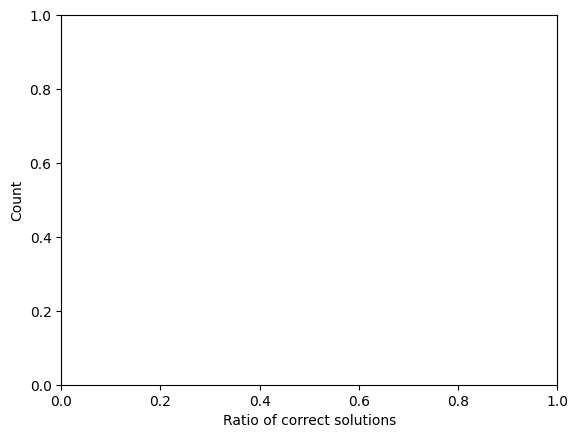

In [22]:
fig, ax = plt.subplots()
sns.histplot(correct_incorrect_ratios, ax=ax, bins=20, kde=True, color="blue", alpha=0.5)
ax.set_xlabel("Ratio of correct solutions")
ax.set_ylabel("Count")
plt.show()